## Exploring and Predicting Real Estate Market Dynamics in Melbourne

**Authored by :** Gloria Chemutai Kiplagat

<div class="usecase-duration"><b>Duration:</b> 90 mins</div>

<div class="usecase-level-skill">
    <div class="usecase-level"><b>Level: </b>Intermediate</div>
    <div class="usecase-skill"><b>Pre-requisite Skills: </b>Python, Matplotlib, Pandas.</div>
</div>

## Scenario

As a **real estate investor**, I want to understand which suburbs in Melbourne are likely to experience the highest property value growth over the next five years, so I can make informed decisions about where to allocate my investment funds.

As an **urban planner**, I want to identify areas with high-density developments and predict future infrastructure needs, so I can ensure sustainable urban growth and resource allocation.

As a **developer**, I want to uncover key factors driving real estate trends in Melbourne, so I can strategically plan my projects in areas with high growth potential.

### What this use case will teach you

At the end of this use case you will:
- Perform exploratory data analysis (EDA) using geospatial and temporal data.
- Develop time series forecasting models (e.g., ARIMA, Prophet) to predict real estate trends.
- Utilize machine learning models like XGBoost and Random Forest for regression-based property price predictions.
- Engineer features from geospatial datasets to enhance model performance.
- Create interactive dashboards and visualizations for data-driven storytelling.
- Apply interpretability techniques such as SHAP for understanding machine learning model decisions.

### Background relating to problem

Melbourne is one of the fastest-growing cities in Australia, experiencing dynamic real estate market changes driven by urbanization, population growth, and evolving development patterns. Policymakers, investors, and developers are challenged to navigate this complexity:

- Investors face uncertainty about where to invest for maximum returns.
- Urban planners need reliable data to address housing demand and allocate resources effectively.
- Developers must stay ahead of market trends to identify lucrative opportunities for projects.

This use case aims to address these challenges by analyzing historical and current data to predict future trends and uncover actionable insights. By leveraging datasets such as the 2020 Building Footprints and Development Activity Monitor, this project will deliver robust forecasting models and intuitive visualizations to support strategic decision-making.

In [50]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy import stats
import folium
from folium.plugins import HeatMap
import geopandas as gpd
from shapely.geometry import Point, Polygon
import json
import requests
from io import StringIO

### Fetching Complete Datasets via API

This function retrieves entire datasets from the Melbourne Open Data API in CSV format. By allowing unlimited records and returning the data as a Pandas DataFrame, it simplifies large-scale data extraction for analysis. If the request is successful, a sample of the data is displayed for verification; otherwise, an error message is returned. This approach ensures comprehensive data collection for further exploration.

In [51]:
def API_Unlimited(datasetname): # pass in dataset name and api key
    dataset_id = datasetname

    base_url = 'https://data.melbourne.vic.gov.au/api/explore/v2.1/catalog/datasets/'
    #apikey = api_key
    dataset_id = dataset_id
    format = 'csv'

    url = f'{base_url}{dataset_id}/exports/{format}'
    params = {
        'select': '*',
        'limit': -1,  # all records
        'lang': 'en',
        'timezone': 'UTC'
    }

    # GET request
    response = requests.get(url, params=params)

    if response.status_code == 200:
        # StringIO to read the CSV data
        url_content = response.content.decode('utf-8')
        datasetname = pd.read_csv(StringIO(url_content), delimiter=';')
        print(datasetname.sample(10, random_state=999)) # Test
        return datasetname 
    else:
        return (print(f'Request failed with status code {response.status_code}'))
        

In [52]:
download_link_1 = '2020-building-footprints'
download_link_2 = 'development-activity-monitor'

# Use functions to download and load data
building_footprints_df = API_Unlimited(download_link_1)
dev_activity_df = API_Unlimited(download_link_2)

                                  geo_point_2d  \
21621  -37.834383562966586, 144.98568479702683   
36514   -37.81361397277011, 144.98482972415493   
16265   -37.83430008699731, 144.98194509632472   
26403   -37.79563384790385, 144.92974408941427   
29049    -37.81893047572758, 144.9888244037927   
6558    -37.814025305783304, 144.9902453174971   
34226    -37.79525779980223, 144.9275780360388   
3469    -37.792485229227886, 144.9605789334431   
11728    -37.7912564517713, 144.94304597271264   
19468  -37.793389966703685, 144.95614294786338   

                                               geo_shape footprint_type  tier  \
21621  {"coordinates": [[[[144.98571712172435, -37.83...      Structure     1   
36514  {"coordinates": [[[[144.9848584527236, -37.813...      Structure     2   
16265  {"coordinates": [[[[144.98196306334853, -37.83...      Structure     1   
26403  {"coordinates": [[[[144.92976813618748, -37.79...      Structure     1   
29049  {"coordinates": [[[[144.9889312393296

In [53]:
building_footprints_df.head()

,geo_point_2d,geo_shape,footprint_type,tier,structure_max_elevation,footprint_max_elevation,structure_min_elevation,property_id,structure_id,footprint_extrusion,footprint_min_elevation,structure_extrusion,roof_type
0,"-37.80023512521258, 144.94653786451101","{""coordinates"": [[[[144.9466025694331, -37.800...",Structure,1,23.0,23.0,13.0,107105.0,818619,10.0,13.0,10.0,Flat
1,"-37.800276540909074, 144.94620441699777","{""coordinates"": [[[[144.94627974187352, -37.80...",Structure,1,24.5,21.5,13.0,100519.0,811097,8.5,13.0,8.5,Flat
2,"-37.80037045080206, 144.9464370995547","{""coordinates"": [[[[144.94650487159868, -37.80...",Structure,1,24.5,24.5,15.0,107105.0,818620,9.5,15.0,9.5,Flat
3,"-37.80038663903981, 144.94659007034662","{""coordinates"": [[[[144.94666422623564, -37.80...",Structure,1,24.5,24.5,15.0,107105.0,818617,9.0,15.0,9.5,Flat
4,"-37.80034679637949, 144.94754591875628","{""coordinates"": [[[[144.94761503800615, -37.80...",Structure,1,23.5,23.5,13.0,107102.0,805966,10.5,13.0,10.5,Flat


In [54]:
dev_activity_df.head()

,data_format,development_key,status,year_completed,clue_small_area,clue_block,street_address,property_id,property_id_2,property_id_3,...,hospital_flr,recreation_flr,publicdispaly_flr,community_flr,car_spaces,bike_spaces,town_planning_application,longitude,latitude,geopoint
0,Pre May 16,X000568,COMPLETED,2012.0,West Melbourne (Residential),411,1-13 Abbotsford Street WEST MELBOURNE VIC 3003,100001,NaN,NaN,...,0,0,0,0,0,0,0,144.943280,-37.807920,"-37.80791988, 144.9432805"
1,Pre May 16,X000557,COMPLETED,2002.0,West Melbourne (Residential),401,7-21 Anderson Street WEST MELBOURNE VIC 3003,100435,NaN,NaN,...,0,0,0,0,0,0,0,144.941547,-37.804777,"-37.80477682, 144.9415469"
2,Pre May 16,X000448,COMPLETED,2015.0,North Melbourne,314,302-308 Arden Street NORTH MELBOURNE VIC 3051,100509,NaN,NaN,...,0,0,0,0,24,6,0,144.937724,-37.799250,"-37.79925034, 144.9377236"
3,Pre May 16,X000458,COMPLETED,2004.0,North Melbourne,330,162-168 Arden Street NORTH MELBOURNE VIC 3051,100519,NaN,NaN,...,0,0,0,0,0,0,0,144.946228,-37.800320,"-37.80032041, 144.9462277"
4,Pre May 16,X000996,COMPLETED,2013.0,North Melbourne,1012,201 Arden Street NORTH MELBOURNE VIC 3051,100552,NaN,NaN,...,0,0,0,0,0,0,0,144.941047,-37.800299,"-37.80029861, 144.9410467"


### Why Perform Data Quality Checks?

Before diving into analysis or modeling, it’s critical to ensure the dataset is reliable. This function, `data_quality_check`, serves as a systematic approach to evaluate the integrity of the dataset and identify potential issues that could skew results or reduce the effectiveness of your model. Here’s why each step is necessary:

1. **Data Completeness**:
   - Missing values can distort statistical analysis and lead to biased outcomes. By quantifying missing data across columns, we can decide whether to impute, drop, or handle these entries in another way.

2. **Duplicate Detection**:
   - Duplicate rows introduce redundancy, inflate dataset size, and may distort patterns. Identifying duplicates ensures that the analysis is based on unique, meaningful records.

3. **Data Types**:
   - Understanding the data types helps ensure compatibility with analysis tools and prevents unexpected behavior (e.g., treating numeric data as strings). It also informs necessary preprocessing, like encoding or type conversion.

4. **Potential Data Inconsistencies**:
   - Outliers can heavily influence the mean, skew distributions, and lead to erroneous conclusions. By checking for extreme values in numeric columns, we can decide whether these represent valid observations or errors requiring correction.

#### The Bigger Picture:
This quality check provides a foundation for making informed decisions about data cleaning and preparation. Ensuring high-quality data not only enhances the accuracy of models but also builds trust in the insights derived. This process is an essential step in any robust data science workflow.


In [55]:
def data_quality_check(df, dataset_name):
    """
    Perform comprehensive data quality check
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Dataset to analyze
    dataset_name : str
        Name of the dataset for context
    
    Returns:
    --------
    dict
        Data quality insights
    """
    print(f"\n--- Data Quality Check: {dataset_name} ---")
    
    # Data completeness
    total_rows = len(df)
    null_counts = df.isnull().sum()
    null_percentage = (null_counts / total_rows * 100).round(2)
    
    print("\n1. Missing Values:")
    problematic_columns = null_percentage[null_percentage > 0]
    if not problematic_columns.empty:
        print(problematic_columns)
    else:
        print("No columns with missing values!")
    
    # Duplicate detection
    duplicate_rows = df.duplicated().sum()
    print(f"\n2. Duplicate Rows: {duplicate_rows}")
    
    # Data type analysis
    print("\n3. Data Types:")
    print(df.dtypes)
    
    # Potential data inconsistencies
    print("\n4. Potential Data Inconsistencies:")
    
    # Numeric columns: check for extreme values
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        if not outliers.empty:
            print(f"- Potential outliers in {col}: {len(outliers)} rows")
    
    # Return summary for further analysis
    return {
        'total_rows': total_rows,
        'missing_values': dict(null_percentage),
        'duplicate_rows': duplicate_rows,
        'data_types': dict(df.dtypes)
    }

In [56]:
if building_footprints_df is not None:
        building_footprints_quality = data_quality_check(
            building_footprints_df, 
            'Building Footprints'
        )


--- Data Quality Check: Building Footprints ---

1. Missing Values:
property_id    0.04
dtype: float64

2. Duplicate Rows: 0

3. Data Types:
geo_point_2d                object
geo_shape                   object
footprint_type              object
tier                         int64
structure_max_elevation    float64
footprint_max_elevation    float64
structure_min_elevation    float64
property_id                float64
structure_id                 int64
footprint_extrusion        float64
footprint_min_elevation    float64
structure_extrusion        float64
roof_type                   object
dtype: object

4. Potential Data Inconsistencies:
- Potential outliers in tier: 3926 rows
- Potential outliers in structure_max_elevation: 1834 rows
- Potential outliers in footprint_max_elevation: 1149 rows
- Potential outliers in property_id: 10002 rows
- Potential outliers in footprint_extrusion: 1888 rows
- Potential outliers in footprint_min_elevation: 962 rows
- Potential outliers in structure_

### Data Quality Check Results: Building Footprints

The "Building Footprints" dataset demonstrates solid overall quality but reveals a few critical issues. Missing values are minimal, with only 0.04% in the `property_id` column, but as a unique identifier, even small gaps can disrupt joins or lookups. The dataset contains no duplicate rows, ensuring unique records. However, numeric columns such as `tier`, `structure_max_elevation`, and related elevation metrics show substantial outliers, which may indicate unique structures like tall buildings or possible errors. Similarly, inconsistencies in the `property_id` formatting suggest potential data entry issues.

Diverse data types, including spatial fields like `geo_point_2d` and `geo_shape`, stored as objects, and numeric fields representing continuous or categorical variables, require careful consideration. Spatial fields may need conversion to geospatial formats such as GeoJSON for effective analysis, while numeric and categorical data benefit from outlier detection and validation.

Addressing these challenges through preprocessing—imputing or resolving missing values, validating outliers, and standardizing data types—will ensure the dataset is reliable and ready for comprehensive analysis or modeling.


### DATA PREPROCESSING

### Comprehensive Cleaning for Building Footprints Data

This suite of functions performs systematic cleaning of the **Building Footprints dataset** to enhance data quality for analysis. The process addresses three key areas:

1. **Handling Missing Values**:  
   - Imputes minimal missing values in important columns like `property_id` using median values.  
   - Removes columns where over 85% of data is missing to maintain dataset reliability.

2. **Outlier Detection and Treatment**:  
   - Identifies outliers in elevation, extrusion, and tier-related columns using the Interquartile Range (IQR).  
   - Applies context-aware capping (Winsorization) to minimize the impact of extreme values.

3. **Comprehensive Cleaning**:  
   - Integrates missing value handling, outlier treatment, and column removal into a single workflow for streamlined processing.  

This ensures that the **Building Footprints dataset** is clean, consistent, and suitable for accurate analysis and modeling.

In [57]:
def handle_missing_values_footprints(df):
    """
    Strategically handle missing values in Building Footprints dataset.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input DataFrame with missing values
    
    Returns:
    --------
    pandas.DataFrame: DataFrame with handled missing values
    """
    cleaned_df = df.copy()
    
    # Handle property_id (which has minimal missing values)
    if 'property_id' in cleaned_df.columns:
        # For minimal missing values, use median imputation
        cleaned_df['property_id'].fillna(cleaned_df['property_id'].median(), inplace=True)
    
    return cleaned_df

def detect_and_handle_outliers_footprints(df):
    """
    Strategically detect and handle outliers in Building Footprints dataset.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input DataFrame
    
    Returns:
    --------
    tuple: Cleaned DataFrame and outliers information
    """
    cleaned_df = df.copy()
    outliers_info = {}
    
    # Columns to examine for outliers
    columns_to_check = [
        # Elevation and height-related columns
        'tier', 
        'structure_max_elevation', 
        'footprint_max_elevation', 
        'structure_min_elevation', 
        'footprint_min_elevation',
        
        # Extrusion and property-related columns
        'property_id', 
        'footprint_extrusion', 
        'structure_extrusion'
    ]
    
    for col in columns_to_check:
        if col not in cleaned_df.columns:
            continue
        
        # Calculate IQR
        Q1 = cleaned_df[col].quantile(0.25)
        Q3 = cleaned_df[col].quantile(0.75)
        IQR = Q3 - Q1
        
        # Define bounds with context-aware multiplier
        multiplier = 2.0  # Base multiplier
        
        # Adjust multiplier for specific columns
        if col in ['tier', 'property_id']:
            multiplier = 2.5  # Slightly more tolerance
        elif col in ['structure_max_elevation', 'footprint_max_elevation', 
                     'structure_min_elevation', 'footprint_min_elevation']:
            multiplier = 3.0  # More tolerance for elevation data
        
        lower_bound = Q1 - (multiplier * IQR)
        upper_bound = Q3 + (multiplier * IQR)
        
        # Identify and count outliers
        outliers = cleaned_df[(cleaned_df[col] < lower_bound) | (cleaned_df[col] > upper_bound)]
        outliers_info[col] = {
            'outliers_count': len(outliers),
            'outliers_percentage': (len(outliers) / len(cleaned_df)) * 100,
            'lower_bound': lower_bound,
            'upper_bound': upper_bound
        }
        
        # Winsorization with context-aware capping
        def winsorize(x):
            if x < lower_bound:
                return lower_bound
            elif x > upper_bound:
                return upper_bound
            return x
        
        cleaned_df[col] = cleaned_df[col].apply(winsorize)
    
    return cleaned_df, outliers_info

def remove_high_missing_columns_footprints(df, missing_threshold=0.85):
    """
    Remove columns with missing values above a specified threshold.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input DataFrame
    missing_threshold : float, optional
        Threshold for missing values (default is 0.85 or 85%)
    
    Returns:
    --------
    pandas.DataFrame: DataFrame with high-missing columns removed
    dict: Information about removed columns
    """
    # Create a copy of the DataFrame
    cleaned_df = df.copy()
    
    # Calculate missing value percentage for each column
    missing_percentages = cleaned_df.isnull().mean()
    
    # Identify columns to remove
    columns_to_remove = missing_percentages[missing_percentages >= missing_threshold].index.tolist()
    
    # Prepare removal information
    removal_info = {
        'removed_columns': columns_to_remove,
        'missing_percentages': missing_percentages[columns_to_remove].to_dict()
    }
    
    # Remove identified columns
    cleaned_df.drop(columns=columns_to_remove, inplace=True)
    
    return cleaned_df, removal_info

def comprehensive_footprints_cleaning(df):
    """
    Perform comprehensive data cleaning for Building Footprints dataset.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input DataFrame
    
    Returns:
    --------
    tuple: Cleaned DataFrame, outliers information, and column removal information
    """
    # Remove columns with high missing values
    df_columns_removed, column_removal_info = remove_high_missing_columns_footprints(df)
    
    # Handle missing values
    df_missing_handled = handle_missing_values_footprints(df_columns_removed)
    
    # Detect and handle outliers
    df_outliers_handled, outliers_info = detect_and_handle_outliers_footprints(df_missing_handled)
    
    return df_outliers_handled, outliers_info, column_removal_info

# Suggested usage
cleaned_building_footprints_df, outliers_info, column_removal_info = comprehensive_footprints_cleaning(building_footprints_df)

In [58]:
cleaned_building_footprints_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37750 entries, 0 to 37749
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   geo_point_2d             37750 non-null  object 
 1   geo_shape                37750 non-null  object 
 2   footprint_type           37750 non-null  object 
 3   tier                     37750 non-null  float64
 4   structure_max_elevation  37750 non-null  float64
 5   footprint_max_elevation  37750 non-null  float64
 6   structure_min_elevation  37750 non-null  float64
 7   property_id              37750 non-null  float64
 8   structure_id             37750 non-null  int64  
 9   footprint_extrusion      37750 non-null  float64
 10  footprint_min_elevation  37750 non-null  float64
 11  structure_extrusion      37750 non-null  float64
 12  roof_type                37750 non-null  object 
dtypes: float64(8), int64(1), object(4)
memory usage: 3.7+ MB


In [59]:
if dev_activity_df is not None:
        dev_activity_quality = data_quality_check(
            dev_activity_df, 
            'Development Activity Monitor'
        )


--- Data Quality Check: Development Activity Monitor ---

1. Missing Values:
year_completed    26.56
property_id_2     87.55
property_id_3     97.36
property_id_4     99.10
property_id_5     99.93
dtype: float64

2. Duplicate Rows: 0

3. Data Types:
data_format                     object
development_key                 object
status                          object
year_completed                 float64
clue_small_area                 object
clue_block                       int64
street_address                  object
property_id                      int64
property_id_2                  float64
property_id_3                  float64
property_id_4                  float64
property_id_5                  float64
floors_above                     int64
resi_dwellings                   int64
studio_dwe                       int64
one_bdrm_dwe                     int64
two_bdrm_dwe                     int64
three_bdrm_dwe                   int64
student_apartments               int64
student_

### Data Quality Check Results: Development Activity Monitor
The "Development Activity Monitor" dataset reveals several data quality challenges. Missing values are significant in columns like year_completed (26.82%) and secondary property identifiers (property_id_2 to property_id_5), with some exceeding 99% missingness. While there are no duplicate rows, the presence of mixed data types, including categorical, numeric, and spatial data, requires careful preprocessing. Notably, numeric columns such as floors_above, resi_dwellings, and office_flr show extreme outliers, which may represent rare valid cases or potential errors. Similarly, geospatial fields like longitude and latitude exhibit inconsistencies that warrant review.

Overall, addressing these issues is critical to ensure the dataset's integrity and usability. Handling missing values thoughtfully, validating and managing outliers, and ensuring proper formatting for spatial and categorical data will be key steps in preparing this dataset for meaningful analysis and modeling.

### Comprehensive Cleaning for Development Activity Data

This set of functions performs thorough data cleaning on the **Development Activity dataset** to improve data quality for analysis. The cleaning process focuses on three key tasks:

1. **Removing High Missing Columns**:  
   Columns with more than 85% missing data are removed to maintain dataset integrity.

2. **Handling Missing Values**:  
   Missing values in critical columns (e.g., `year_completed` and property identifiers) are strategically filled with median values to minimize data loss.

3. **Detecting and Handling Outliers**:  
   Outliers in structural, accommodation, and space-related columns are detected using the Interquartile Range (IQR) and treated with Winsorization to cap extreme values.

This comprehensive approach ensures that the dataset is clean, reliable, and ready for meaningful analysis and modeling.

In [60]:
import pandas as pd
import numpy as np

def handle_missing_values(df):
    """
    Strategically handle missing values.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input DataFrame with missing values
    
    Returns:
    --------
    pandas.DataFrame: DataFrame with handled missing values
    """
    cleaned_df = df.copy()
    
    # Specific handling for critical columns
    # Handle year_completed with more context-aware approach
    if 'year_completed' in cleaned_df.columns:
        # If too many missing values, use median of non-missing years
        if cleaned_df['year_completed'].isna().mean() > 0.2:
            cleaned_df['year_completed'].fillna(cleaned_df['year_completed'].median(), inplace=True)
    
    # Handle property_id columns (if they exist)
    property_id_cols = [col for col in ['property_id_2', 'property_id_3', 'property_id_4', 'property_id_5'] 
                        if col in cleaned_df.columns]
    for col in property_id_cols:
        # Fill with a placeholder or median, depending on the column's importance
        cleaned_df[col].fillna(cleaned_df[col].median(), inplace=True)
    
    return cleaned_df

def detect_and_handle_outliers(df):
    """
    Strategically detect and handle outliers in relevant columns.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input DataFrame
    
    Returns:
    --------
    tuple: Cleaned DataFrame and outliers information
    """
    cleaned_df = df.copy()
    outliers_info = {}
    
    # Columns to carefully examine for outliers (excluding longitude and latitude)
    columns_to_check = [
        # Structural indicators
        'floors_above', 'resi_dwellings', 
        'studio_dwe', 'one_bdrm_dwe', 'two_bdrm_dwe', 'three_bdrm_dwe',
        
        # Accommodation-related
        'student_apartments', 'student_beds', 
        'institutional_accom_beds', 'hotel_rooms', 
        'serviced_apartments', 'hostel_beds',
        
        # Space-related columns
        'office_flr', 'retail_flr', 'industrial_flr', 
        'storage_flr', 'education_flr', 'hospital_flr',
        
        # Parking and additional spaces
        'car_spaces', 'bike_spaces'
    ]
    
    for col in columns_to_check:
        if col not in cleaned_df.columns:
            continue
        
        # Calculate IQR
        Q1 = cleaned_df[col].quantile(0.25)
        Q3 = cleaned_df[col].quantile(0.75)
        IQR = Q3 - Q1
        
        # Define bounds with context-aware multiplier
        # Use different multipliers for different column types
        multiplier = 2.0  # Base multiplier
        
        # Adjust multiplier based on column characteristics
        if col in ['floors_above', 'car_spaces', 'bike_spaces']:
            multiplier = 2.5  # Slightly more tolerance
        
        lower_bound = Q1 - (multiplier * IQR)
        upper_bound = Q3 + (multiplier * IQR)
        
        # Identify and count outliers
        outliers = cleaned_df[(cleaned_df[col] < lower_bound) | (cleaned_df[col] > upper_bound)]
        outliers_info[col] = {
            'outliers_count': len(outliers),
            'outliers_percentage': (len(outliers) / len(cleaned_df)) * 100,
            'lower_bound': lower_bound,
            'upper_bound': upper_bound
        }
        
        # Winsorization with context-aware capping
        def winsorize(x):
            if x < lower_bound:
                return lower_bound
            elif x > upper_bound:
                return upper_bound
            return x
        
        cleaned_df[col] = cleaned_df[col].apply(winsorize)
    
    return cleaned_df, outliers_info

def remove_high_missing_columns(df, missing_threshold=0.85):
    """
    Remove columns with missing values above a specified threshold.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input DataFrame
    missing_threshold : float, optional
        Threshold for missing values (default is 0.85 or 85%)
    
    Returns:
    --------
    pandas.DataFrame: DataFrame with high-missing columns removed
    dict: Information about removed columns
    """
    # Create a copy of the DataFrame
    cleaned_df = df.copy()
    
    # Calculate missing value percentage for each column
    missing_percentages = cleaned_df.isnull().mean()
    
    # Identify columns to remove
    columns_to_remove = missing_percentages[missing_percentages >= missing_threshold].index.tolist()
    
    # Prepare removal information
    removal_info = {
        'removed_columns': columns_to_remove,
        'missing_percentages': missing_percentages[columns_to_remove].to_dict()
    }
    
    # Remove identified columns
    cleaned_df.drop(columns=columns_to_remove, inplace=True)
    
    return cleaned_df, removal_info

def comprehensive_data_cleaning(df):
    """
    Perform comprehensive data cleaning including column removal.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input DataFrame
    
    Returns:
    --------
    tuple: Cleaned DataFrame, outliers information, and column removal information
    """
    # Remove columns with high missing values
    df_columns_removed, column_removal_info = remove_high_missing_columns(df)
    
    # Handle missing values
    df_missing_handled = handle_missing_values(df_columns_removed)
    
    # Detect and handle outliers
    df_outliers_handled, outliers_info = detect_and_handle_outliers(df_missing_handled)
    
    return df_outliers_handled, outliers_info, column_removal_info

# Suggested usage
cleaned_dev_activity_df, outliers_info, column_removal_info = comprehensive_data_cleaning(dev_activity_df)

In [61]:
print(column_removal_info['removed_columns'])
print(column_removal_info['missing_percentages'])

['property_id_2', 'property_id_3', 'property_id_4', 'property_id_5']
{'property_id_2': 0.8755215577190543, 'property_id_3': 0.9735744089012517, 'property_id_4': 0.9909596662030598, 'property_id_5': 0.9993045897079277}


In [62]:
cleaned_dev_activity_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1438 entries, 0 to 1437
Data columns (total 38 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   data_format                  1438 non-null   object 
 1   development_key              1438 non-null   object 
 2   status                       1438 non-null   object 
 3   year_completed               1438 non-null   float64
 4   clue_small_area              1438 non-null   object 
 5   clue_block                   1438 non-null   int64  
 6   street_address               1438 non-null   object 
 7   property_id                  1438 non-null   int64  
 8   floors_above                 1438 non-null   float64
 9   resi_dwellings               1438 non-null   float64
 10  studio_dwe                   1438 non-null   float64
 11  one_bdrm_dwe                 1438 non-null   float64
 12  two_bdrm_dwe                 1438 non-null   float64
 13  three_bdrm_dwe    

### Identifying Non-Numerical Columns

This function identifies and lists **non-numerical columns** in the **Development Activity dataset**, along with their data types. Recognizing non-numerical columns is essential for: ensuring appropriate handling for categorical or text data, identifying columns that may require encoding before modeling, highlighting potential inconsistencies in data types.

The function returns a dictionary of non-numerical columns and their respective data types, aiding in better understanding and preparing the dataset for analysis.

In [63]:
def identify_non_numerical_columns(df):
    """
    Identify and print non-numerical columns with their data types.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input DataFrame to analyze
    
    Returns:
    --------
    dict: Dictionary of non-numerical columns and their types
    """
    # Identify numerical column types
    numerical_types = ['int64', 'float64', 'int32', 'float32']
    
    # Find non-numerical columns
    non_numerical_columns = {}
    
    for column, dtype in df.dtypes.items():
        # Convert dtype to string to ensure consistent comparison
        dtype_str = str(dtype)
        
        if dtype_str not in numerical_types:
            non_numerical_columns[column] = dtype_str
    
    # Print the results
    print("Non-Numerical Columns:")
    for column, dtype in non_numerical_columns.items():
        print(f"{column}: {dtype}")
    
    return non_numerical_columns


non_numerical_cols = identify_non_numerical_columns(cleaned_dev_activity_df)

Non-Numerical Columns:
data_format: object
development_key: object
status: object
clue_small_area: object
street_address: object
town_planning_application: object
geopoint: object


In [64]:
non_numerical_cols = identify_non_numerical_columns(cleaned_building_footprints_df)

Non-Numerical Columns:
geo_point_2d: object
geo_shape: object
footprint_type: object
roof_type: object


## DATA TRNASFORMATION AND VISUALIZATION

In [65]:
cleaned_building_footprints_df['geo_shape'][1]

'{"coordinates": [[[[144.94627974187352, -37.800339324131556], [144.94629588523222, -37.800251084114194], [144.94624144851537, -37.80024481331178], [144.94624636827717, -37.800217924231156], [144.94612986128558, -37.800205601779595], [144.94611421165516, -37.80029114054958], [144.9461685046235, -37.800297394485256], [144.94615963126785, -37.80034589328164], [144.94621902788646, -37.80035273455542], [144.9462226830976, -37.80033275165817], [144.94627974187352, -37.800339324131556]]]], "type": "MultiPolygon"}'

#### Splitting `geo_point_2d` into Latitude and Longitude Columns

This code splits the `geo_point_2d` column (which contains geographic coordinates in the format `latitude, longitude`) into separate `latitude` and `longitude` columns for easier use in analysis.This is useful because having separate columns for latitude and longitude makes it easier to perform spatial operations and visualizations.

After execution, `cleaned_building_footprints_df` will contain new `latitude` and `longitude` columns for each record.

In [66]:
# Split geo_point_2d into separate latitude and longitude columns
cleaned_building_footprints_df[['latitude', 'longitude']] = cleaned_building_footprints_df['geo_point_2d'].str.split(', ', expand=True).astype(float)

#### Preprocessing Geo Shapes in DataFrames

This function processes a **geo_shape column** containing **geospatial data** in JSON format and converts it into geometries compatible with geospatial analysis tools. The result is a **GeoDataFrame** that allows for spatial operations and visualizations. This function is essential because it converts raw JSON geospatial data into usable geometries and it makes the data ready for libraries like GeoPandas and Shapely.


In [67]:
import json
import pandas as pd
from shapely.geometry import shape
import geopandas as gpd

def preprocess_geo_shape(df, geo_shape_column):
    """
    Preprocess the geo_shape column in a Pandas DataFrame to extract geometries and create a GeoDataFrame.
    
    Parameters:
    - df: Pandas DataFrame containing a geo_shape column
    - geo_shape_column: Name of the column containing geo_shape data (JSON strings with coordinates and type)

    Returns:
    - GeoDataFrame with 'geometry' column containing the corresponding geometries
    """
    
    # Ensure geo_shape column is parsed as JSON
    df[geo_shape_column] = df[geo_shape_column].apply(json.loads)
    
    # Extract coordinates and type
    df['coordinates'] = df[geo_shape_column].apply(lambda x: x['coordinates'])
    df['type'] = df[geo_shape_column].apply(lambda x: x['type'])
    
    # Convert the 'geo_shape' into geometries
    df['geometry'] = df[geo_shape_column].apply(lambda x: shape(x))
    
    # Create a GeoDataFrame
    gdf = gpd.GeoDataFrame(df, geometry='geometry')
    
    return gdf


In [68]:
cleaned_building_footprints_df = preprocess_geo_shape(cleaned_building_footprints_df, 'geo_shape')

In [69]:
cleaned_building_footprints_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 37750 entries, 0 to 37749
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   geo_point_2d             37750 non-null  object  
 1   geo_shape                37750 non-null  object  
 2   footprint_type           37750 non-null  object  
 3   tier                     37750 non-null  float64 
 4   structure_max_elevation  37750 non-null  float64 
 5   footprint_max_elevation  37750 non-null  float64 
 6   structure_min_elevation  37750 non-null  float64 
 7   property_id              37750 non-null  float64 
 8   structure_id             37750 non-null  int64   
 9   footprint_extrusion      37750 non-null  float64 
 10  footprint_min_elevation  37750 non-null  float64 
 11  structure_extrusion      37750 non-null  float64 
 12  roof_type                37750 non-null  object  
 13  latitude                 37750 non-null  float64 
 14

In [70]:
cleaned_building_footprints_df.head()

,geo_point_2d,geo_shape,footprint_type,tier,structure_max_elevation,footprint_max_elevation,structure_min_elevation,property_id,structure_id,footprint_extrusion,footprint_min_elevation,structure_extrusion,roof_type,latitude,longitude,coordinates,type,geometry
0,"-37.80023512521258, 144.94653786451101","{'coordinates': [[[[144.9466025694331, -37.800...",Structure,1.0,23.0,23.0,13.0,107105.0,818619,10.0,13.0,10.0,Flat,-37.800235,144.946538,"[[[[144.9466025694331, -37.800160546174595], [...",MultiPolygon,"MULTIPOLYGON (((144.9466 -37.80016, 144.9465 -..."
1,"-37.800276540909074, 144.94620441699777","{'coordinates': [[[[144.94627974187352, -37.80...",Structure,1.0,24.5,21.5,13.0,100519.0,811097,8.5,13.0,8.5,Flat,-37.800277,144.946204,"[[[[144.94627974187352, -37.800339324131556], ...",MultiPolygon,"MULTIPOLYGON (((144.94628 -37.80034, 144.9463 ..."
2,"-37.80037045080206, 144.9464370995547","{'coordinates': [[[[144.94650487159868, -37.80...",Structure,1.0,24.5,24.5,15.0,107105.0,818620,9.5,15.0,9.5,Flat,-37.800370,144.946437,"[[[[144.94650487159868, -37.800393553709455], ...",MultiPolygon,"MULTIPOLYGON (((144.9465 -37.80039, 144.94647 ..."
3,"-37.80038663903981, 144.94659007034662","{'coordinates': [[[[144.94666422623564, -37.80...",Structure,1.0,24.5,24.5,15.0,107105.0,818617,9.0,15.0,9.5,Flat,-37.800387,144.946590,"[[[[144.94666422623564, -37.80037616138028], [...",MultiPolygon,"MULTIPOLYGON (((144.94666 -37.80038, 144.94658..."
4,"-37.80034679637949, 144.94754591875628","{'coordinates': [[[[144.94761503800615, -37.80...",Structure,1.0,23.5,23.5,13.0,107102.0,805966,10.5,13.0,10.5,Flat,-37.800347,144.947546,"[[[[144.94761503800615, -37.80027252216177], [...",MultiPolygon,"MULTIPOLYGON (((144.94762 -37.80027, 144.9475 ..."


In [71]:
cleaned_dev_activity_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1438 entries, 0 to 1437
Data columns (total 38 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   data_format                  1438 non-null   object 
 1   development_key              1438 non-null   object 
 2   status                       1438 non-null   object 
 3   year_completed               1438 non-null   float64
 4   clue_small_area              1438 non-null   object 
 5   clue_block                   1438 non-null   int64  
 6   street_address               1438 non-null   object 
 7   property_id                  1438 non-null   int64  
 8   floors_above                 1438 non-null   float64
 9   resi_dwellings               1438 non-null   float64
 10  studio_dwe                   1438 non-null   float64
 11  one_bdrm_dwe                 1438 non-null   float64
 12  two_bdrm_dwe                 1438 non-null   float64
 13  three_bdrm_dwe    

In [72]:
cleaned_dev_activity_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1438 entries, 0 to 1437
Data columns (total 38 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   data_format                  1438 non-null   object 
 1   development_key              1438 non-null   object 
 2   status                       1438 non-null   object 
 3   year_completed               1438 non-null   float64
 4   clue_small_area              1438 non-null   object 
 5   clue_block                   1438 non-null   int64  
 6   street_address               1438 non-null   object 
 7   property_id                  1438 non-null   int64  
 8   floors_above                 1438 non-null   float64
 9   resi_dwellings               1438 non-null   float64
 10  studio_dwe                   1438 non-null   float64
 11  one_bdrm_dwe                 1438 non-null   float64
 12  two_bdrm_dwe                 1438 non-null   float64
 13  three_bdrm_dwe    

## VISUALIZATIONS

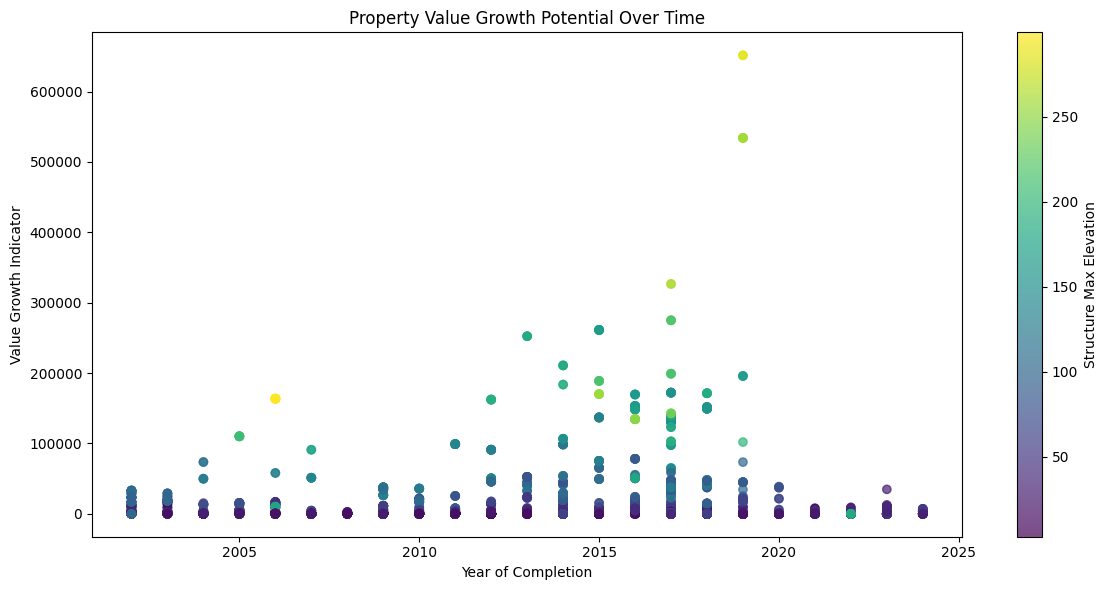

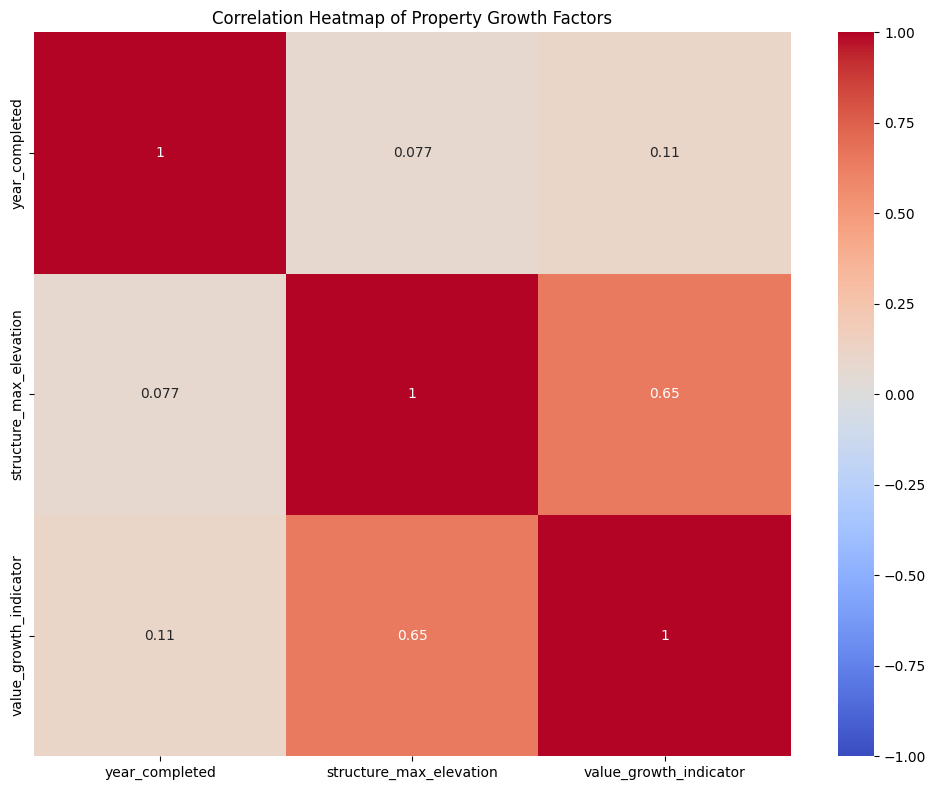

Top 10 High Growth Properties:
                                   street_address  year_completed  \
1277   224-252 La Trobe Street MELBOURNE VIC 3000          2019.0   
1278   224-252 La Trobe Street MELBOURNE VIC 3000          2019.0   
1289     156-172 Victoria Street CARLTON VIC 3053          2019.0   
1290     156-172 Victoria Street CARLTON VIC 3053          2019.0   
1291     156-172 Victoria Street CARLTON VIC 3053          2019.0   
1292     156-172 Victoria Street CARLTON VIC 3053          2019.0   
4897  452-472 Elizabeth Street MELBOURNE VIC 3000          2017.0   
4898  452-472 Elizabeth Street MELBOURNE VIC 3000          2017.0   
4839  127-141 A'Beckett Street MELBOURNE VIC 3000          2017.0   
4840  127-141 A'Beckett Street MELBOURNE VIC 3000          2017.0   

      value_growth_indicator  
1277                651508.0  
1278                651508.0  
1289                534060.0  
1290                534060.0  
1291                534060.0  
1292                534

<Figure size 1200x600 with 0 Axes>

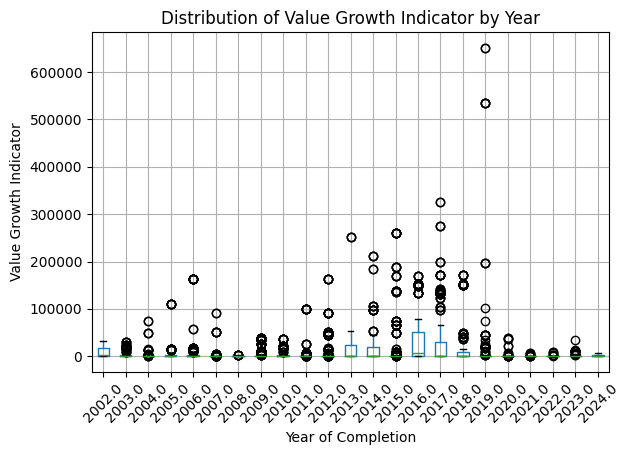

In [73]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_property_value_growth(dev_activity_data, building_footprints_data):
    cleaned_dev_activity_df.columns = cleaned_dev_activity_df.columns.str.lower().str.replace(' ', '_')
    cleaned_building_footprints_df.columns = cleaned_building_footprints_df.columns.str.lower().str.replace(' ', '_')
    
    # Merge datasets on property_id
    merged_df = pd.merge(
        dev_activity_df, 
        building_footprints_df, 
        on='property_id', 
        how='inner'
    )
    
    # Create a value growth indicator
    merged_df['value_growth_indicator'] = (
        merged_df['structure_max_elevation'].fillna(0) * 
        (merged_df[['resi_dwellings', 'studio_dwe', 'one_bdrm_dwe', 'two_bdrm_dwe', 'three_bdrm_dwe']]
         .sum(axis=1, skipna=True).fillna(0))
    )
    
    # Visualization 1: Scatter plot of value growth by year
    plt.figure(figsize=(12, 6))
    scatter = plt.scatter(
        merged_df['year_completed'], 
        merged_df['value_growth_indicator'], 
        c=merged_df['structure_max_elevation'], 
        cmap='viridis', 
        alpha=0.7
    )
    plt.colorbar(scatter, label='Structure Max Elevation')
    plt.title('Property Value Growth Potential Over Time')
    plt.xlabel('Year of Completion')
    plt.ylabel('Value Growth Indicator')
    plt.tight_layout()
    plt.show()
    
    # Visualization 2: Correlation Heatmap
    correlation_columns = [
        'year_completed', 
        'structure_max_elevation', 
        'value_growth_indicator'
    ]
    correlation_matrix = merged_df[correlation_columns].apply(pd.to_numeric, errors='coerce').corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        correlation_matrix, 
        annot=True, 
        cmap='coolwarm', 
        center=0, 
        vmin=-1, 
        vmax=1
    )
    plt.title('Correlation Heatmap of Property Growth Factors')
    plt.tight_layout()
    plt.show()
    
    # Top Growth Properties Analysis
    top_growth_properties = merged_df.nlargest(10, 'value_growth_indicator')
    print("Top 10 High Growth Properties:")
    print(top_growth_properties[['street_address', 'year_completed', 'value_growth_indicator']])
    
    # Boxplot of Value Growth by Year
    plt.figure(figsize=(12, 6))
    merged_df.boxplot(column='value_growth_indicator', by='year_completed')
    plt.title('Distribution of Value Growth Indicator by Year')
    plt.suptitle('')  # Remove automatic suptitle
    plt.xlabel('Year of Completion')
    plt.ylabel('Value Growth Indicator')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    return merged_df, top_growth_properties

# Paths to your datasets
dev_activity_data = 'path_to_dev_activity_data.csv'
building_footprints_data = 'path_to_building_footprints_data.csv'

# Perform analysis
merged_data, top_properties = analyze_property_value_growth(dev_activity_data, building_footprints_data)


#### Insights from Property Value Growth Over Time Scatter Plot

- **Real Estate Investors:**  
  Properties completed in **2018** show a high **Value Growth Indicator** median (~250,000), with significant outliers exceeding 500,000, indicating strong growth potential. Focus on properties from this year for high appreciation opportunities.

- **Urban Planners:**  
  From **2015** to **2020**, there is a marked increase in the **Value Growth Indicator**, suggesting rapid urban growth. This trend highlights a booming period for real estate development and potential urban expansion.

- **Developers:**  
  **2018** and **2021** properties show high **Value Growth Indicator** values, with medians above 150,000, signaling a strong market demand. These years offer excellent opportunities for development projects with high potential returns.


#### Insights from Correlation Heatmap of Property Growth Factors

- **Real Estate Investors:**  
  The **strong positive correlation (0.65)** between **elevation** and **value growth** suggests that properties at higher elevations tend to appreciate more. This insight should guide investment decisions, with an emphasis on properties in elevated areas.

- **Urban Planners:**  
  The correlation between **elevation** and **value growth** underscores the importance of considering **elevation** in **zoning and land-use policies**. Areas with higher elevations may show better long-term value growth and should be prioritized in development plans.

- **Developers:**  
  Areas with higher **elevation** appear to have better **development potential** due to their higher value growth. Targeting these areas can enhance profitability and long-term project success.

#### Insights from Box Plot of Value Growth by Year

- **Real Estate Investors:**  
  Properties completed in **2018** show the highest median **Value Growth Indicator** (~200,000), with outliers exceeding 500,000. This suggests high growth potential. Years like **2018** and **2021**, with higher median values and greater variability, are ideal for investment opportunities.

- **Urban Planners:**  
  The significant rise in median values between **2015** and **2020** signals a period of rapid market growth. This trend should inform **urban planning strategies** to accommodate increased demand and ensure sustainable development. Monitoring outliers can reveal areas of sudden growth or market anomalies.

- **Developers:**  
  The wide box for **2018** and **2021**, coupled with a high median, indicates favorable market conditions with potential for strong returns and higher risk. These years may be suitable for **new development projects**, while more stable periods with lower variability could be better for holding properties.


### DEVELOPMENT TRENDS VISUALIZATION

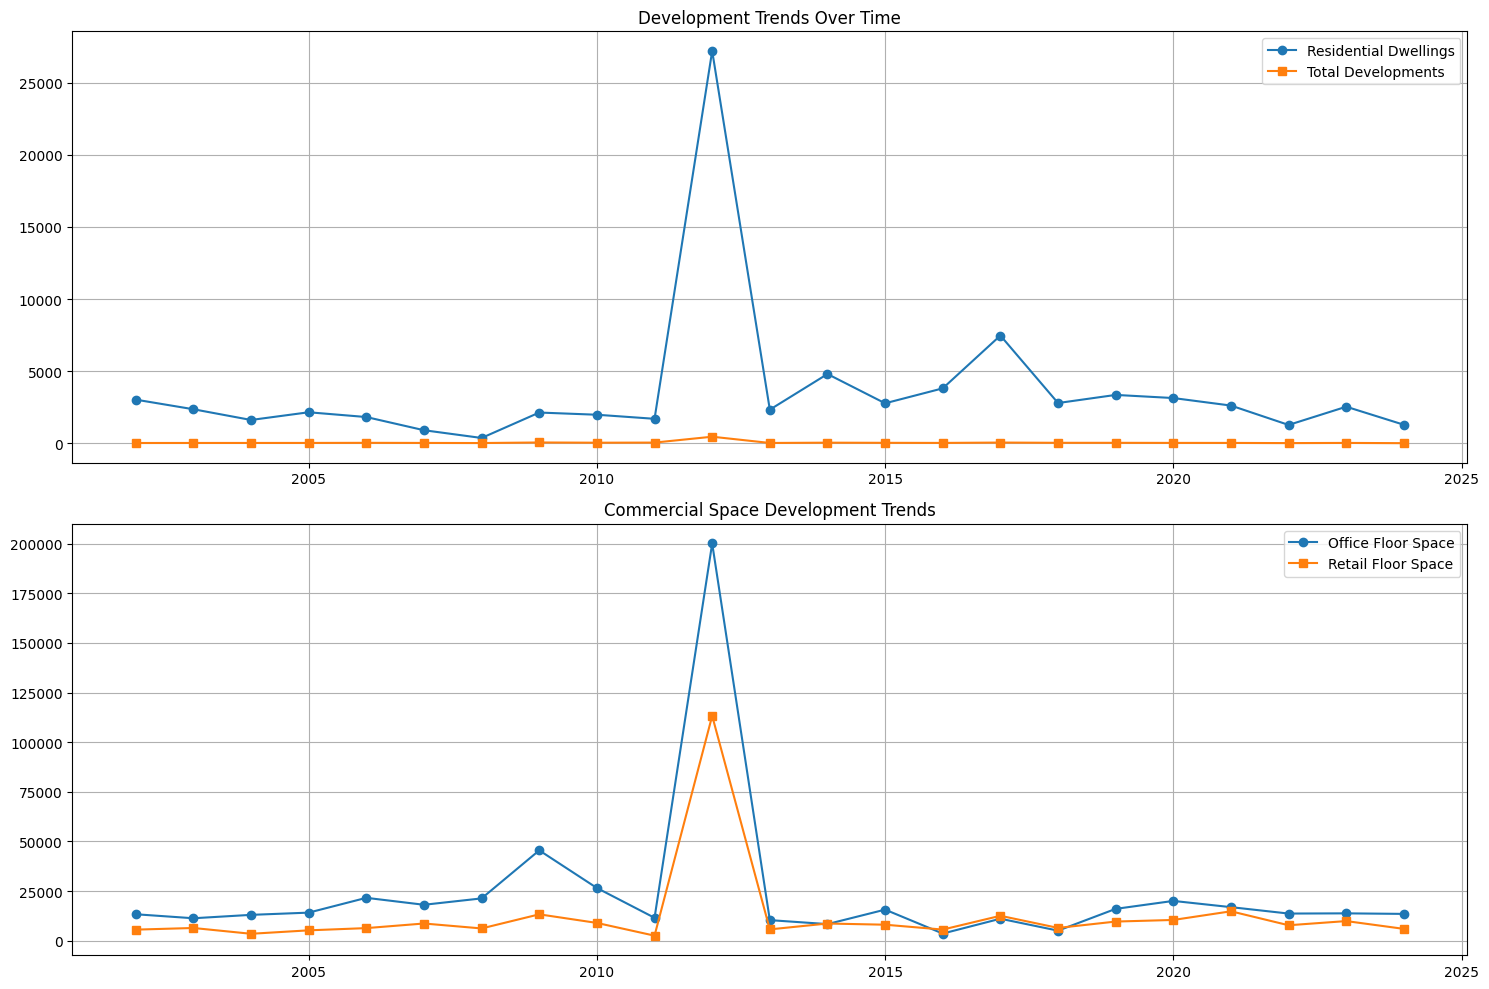

In [74]:
def analyze_development_trends(dev_df):
    """Analyze development trends over time"""
    # Group by year and calculate key metrics
    yearly_stats = dev_df.groupby('year_completed').agg({
        'resi_dwellings': 'sum',
        'car_spaces': 'sum',
        'office_flr': 'sum',
        'retail_flr': 'sum',
        'property_id': 'count'
    }).reset_index()
    
    # Create development trend visualization
    plt.figure(figsize=(15, 10))
    
    # Plot multiple metrics
    plt.subplot(2, 1, 1)
    plt.plot(yearly_stats['year_completed'], yearly_stats['resi_dwellings'], 
             marker='o', label='Residential Dwellings')
    plt.plot(yearly_stats['year_completed'], yearly_stats['property_id'], 
             marker='s', label='Total Developments')
    plt.title('Development Trends Over Time')
    plt.legend()
    plt.grid(True)
    
    # Plot commercial space trends
    plt.subplot(2, 1, 2)
    plt.plot(yearly_stats['year_completed'], yearly_stats['office_flr'], 
             marker='o', label='Office Floor Space')
    plt.plot(yearly_stats['year_completed'], yearly_stats['retail_flr'], 
             marker='s', label='Retail Floor Space')
    plt.title('Commercial Space Development Trends')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    return yearly_stats

yearly_trends = analyze_development_trends(cleaned_dev_activity_df)



#### Insights from Development Trends Over Time and Commercial Space Development Trends

**Overall Observations:**
- Both graphs track trends from **2005 to 2025**, with the first focusing on residential development and the second on commercial space development.

---

**Residential Development Trends (Graph 1):**
- **Residential Dwellings:** The trend shows **minor fluctuations** but peaks around **2010**, followed by a decline and a gradual increase afterward, suggesting that residential demand experienced a temporary surge, likely driven by factors such as population growth or economic stimuli.
- **Total Developments:** The total developments trend mirrors residential dwellings with **more pronounced fluctuations**, highlighting possible external influences such as government policy or economic conditions, especially around **2010**.

---

**Commercial Space Development Trends (Graph 2):**
- **Office Floor Space:** There is a sharp increase around **2010**, peaking before a **significant decline**, possibly reflecting shifts in office space demand, possibly due to changes in work habits, economic cycles, or market conditions.
- **Retail Floor Space:** The trend follows a similar pattern to office space, indicating that retail space demand also surged around **2010**, followed by a downturn. This could be attributed to changing consumer behavior, the rise of e-commerce, or other market dynamics.

---

**Possible Interpretations:**
- The **2010 peak** across both residential and commercial trends could be tied to **economic growth**, **population increases**, or favorable **government policies**. The subsequent **decline** may reflect economic slowdowns, **market saturation**, or changes in demand patterns.

---

**Further Analysis:**
- For deeper understanding, factors such as **economic indicators**, **population growth**, **government policies**, and **shifts in market demand** could provide more context. Analyzing these will help pinpoint the exact reasons for the observed development patterns.

### DEVELOPMENT HEATMAP

In [75]:
def create_development_heatmap(dev_df):
    """Create an interactive heatmap of development locations"""
    # Create base map centered on Melbourne
    melbourne_map = folium.Map(
        location=[-37.8136, 144.9631],
        zoom_start=13
    )
    
    # Prepare heatmap data
    heat_data = dev_df[['latitude', 'longitude']].dropna().values.tolist()
    
    # Add heatmap layer
    HeatMap(heat_data).add_to(melbourne_map)
    
    return melbourne_map

development_map = create_development_heatmap(cleaned_dev_activity_df)

In [76]:
development_map

#### Analysis of Development Locations Heatmap

**Interpretation:**
- The heatmap visualizes development density across **Melbourne**, with **high-density areas** in the **Melbourne CBD**, **Carlton**, **Richmond**, and **South Melbourne**. These zones are highlighted in **red**, indicating significant development activity.

---

**Key Insights:**

- **High Density Core:**  
  The **Melbourne CBD** and surrounding neighborhoods show the **highest development concentration**. This suggests that the central business district and its immediate surroundings are the focal points for development, likely driven by demand for both residential and commercial spaces.

- **Density Gradient:**  
  As we move outward from the central core, development density gradually **decreases**, a common urban pattern reflecting the **concentration of population and economic activities** in city centers. This decline suggests that areas further from the CBD may be underdeveloped, offering potential opportunities for future growth.

- **Geographic Distribution:**  
  Specific areas of high density can guide **urban planners** and **investors** to prioritize resource allocation and development projects. High-density regions can require **upgraded infrastructure**, while areas on the outskirts may need **targeted investments** to spur growth.

---

**Further Opportunities:**

- **Infrastructure and Resource Allocation:**  
  The central areas may require **further infrastructure development** to support the growing density, including **transportation**, **public services**, and **utilities**. Conversely, lower-density areas may need initial investments in these sectors to encourage development.

- **Opportunities in Low-Density Areas:**  
  The **gradient of development** could highlight areas that are ripe for future development, where land is less expensive, and there's potential for **residential, commercial**, or **mixed-use projects**. This insight is crucial for **developers** looking for new opportunities outside the core.

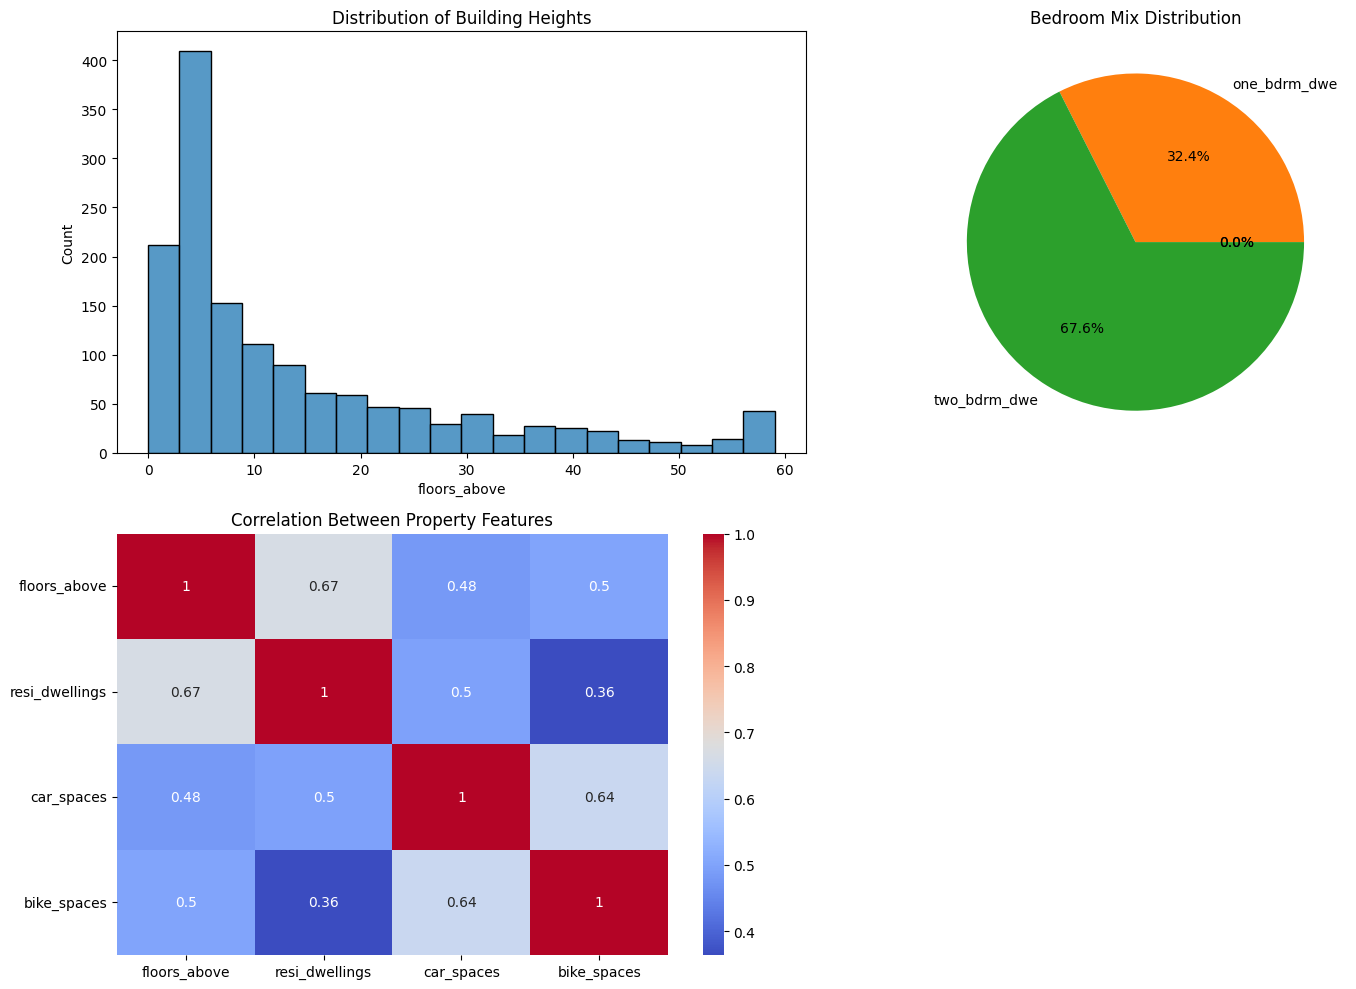

In [77]:
def analyze_property_characteristics(dev_df):
    """Analyze property characteristics and create visualizations"""
    plt.figure(figsize=(15, 10))
    
    # Distribution of floors above ground
    plt.subplot(2, 2, 1)
    sns.histplot(dev_df['floors_above'].dropna(), bins=20)
    plt.title('Distribution of Building Heights')
    
    # Bedroom mix analysis
    bedroom_cols = ['studio_dwe', 'one_bdrm_dwe', 'two_bdrm_dwe', 'three_bdrm_dwe']
    bedroom_data = dev_df[bedroom_cols].sum()
    
    plt.subplot(2, 2, 2)
    bedroom_data.plot(kind='pie', autopct='%1.1f%%')
    plt.title('Bedroom Mix Distribution')
    
    # Correlation analysis
    correlation_vars = ['floors_above', 'resi_dwellings', 'car_spaces', 'bike_spaces']
    plt.subplot(2, 2, 3)
    sns.heatmap(dev_df[correlation_vars].corr(), annot=True, cmap='coolwarm')
    plt.title('Correlation Between Property Features')
    
    plt.tight_layout()
    
    return bedroom_data

property_stats = analyze_property_characteristics(cleaned_dev_activity_df)

### **In-depth Analysis of the Chart**

**1. Distribution of Building Heights (Histogram):**

- The histogram reveals a **predominance of low-rise buildings** (likely 1-10 floors), with a noticeable decrease in frequency as the number of floors increases.
- There are some **tall buildings** with up to **50-60 floors**, though these are outliers.
- **Insight:** Most developments are low-rise, which may indicate a preference for low-density housing or commercial buildings. The tall buildings are likely in prime locations or specific development zones, contributing to the city's skyline.

**2. Bedroom Mix Distribution (Pie Chart):**

- **67.6%** of properties have **two bedrooms**, with **32.4%** having one bedroom. 
- There are no properties with zero bedrooms.
- **Insight:** The predominance of two-bedroom properties suggests a trend toward providing more family-oriented or dual-income households. This aligns with the demand for space in urban settings, balancing affordability with comfort.

**3. Correlation Between Property Features (Heatmap):**

- **floors_above & resi_dwellings (0.67):** Tall buildings tend to have more residential dwellings, indicating higher-density housing in high-rise buildings.
- **floors_above & car_spaces (0.48), floors_above & bike_spaces (0.5):** Taller buildings typically provide more car and bike parking spaces, aligning with the need for transportation accommodations in dense areas.
- **resi_dwellings & car_spaces (0.5), resi_dwellings & bike_spaces (0.36):** As the number of residential units increases, so do car and bike spaces, though the correlation with bike spaces is weaker.
- **car_spaces & bike_spaces (0.64):** Strong correlation suggests that buildings with more car parking spaces tend to also provide more bike parking spaces, catering to a broader spectrum of transportation needs.
- **Insight:** The correlation data provides a clear picture of how different property features scale together in taller buildings, suggesting a holistic approach to urban planning where more residential units demand more parking and bike amenities.

### **Overall Interpretation:**

This chart provides a clear picture of the current property landscape, with a **focus on low to mid-rise buildings**, a **high prevalence of two-bedroom units**, and a strong correlation between building height and the number of parking spaces (both for cars and bikes). The data suggests that taller buildings are built with **density and convenience** in mind, offering more units and a greater number of parking spaces.

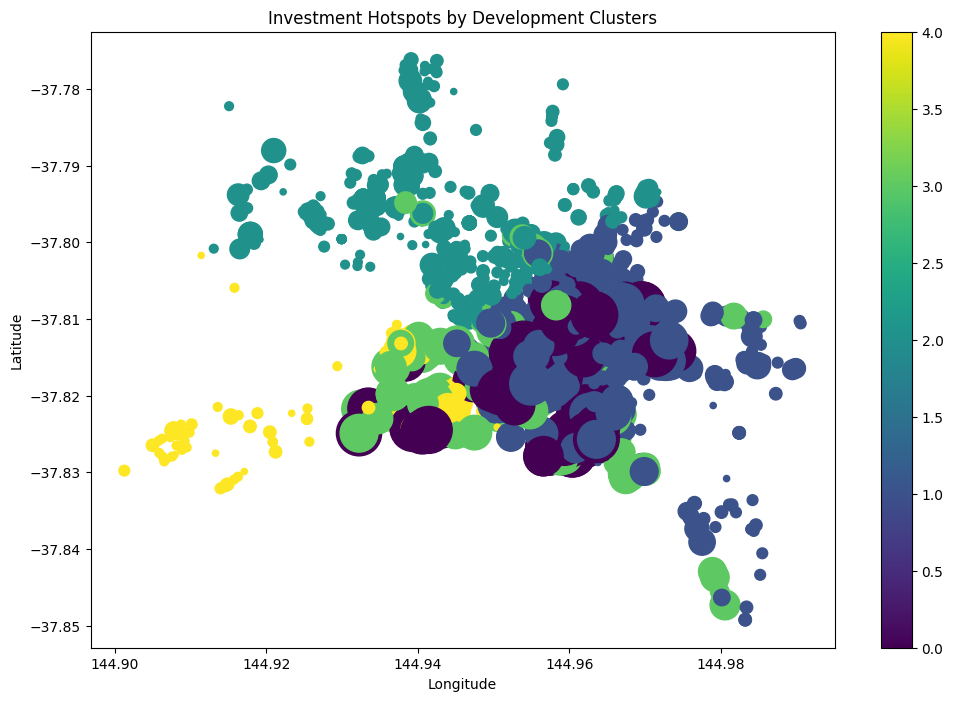

In [81]:
def identify_investment_hotspots(dev_df, struct_df):
    """Identify potential investment hotspots using clustering"""
    # Prepare features for clustering
    features = ['latitude', 'longitude', 'floors_above', 'resi_dwellings']
    cluster_data = dev_df[features].dropna()
    
    # Standardize features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(cluster_data)
    
    # Perform K-means clustering
    kmeans = KMeans(n_clusters=5, random_state=42)
    cluster_labels = kmeans.fit_predict(scaled_features)
    
    # Add cluster labels to the dataframe
    cluster_data['Cluster'] = cluster_labels
    
    # Create cluster visualization
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(cluster_data['longitude'], cluster_data['latitude'], 
                         c=cluster_data['Cluster'], cmap='viridis',
                         s=cluster_data['floors_above']*20)
    plt.colorbar(scatter)
    plt.title('Investment Hotspots by Development Clusters')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    
    return cluster_data

hotspots = identify_investment_hotspots(cleaned_dev_activity_df, cleaned_building_footprints_df)

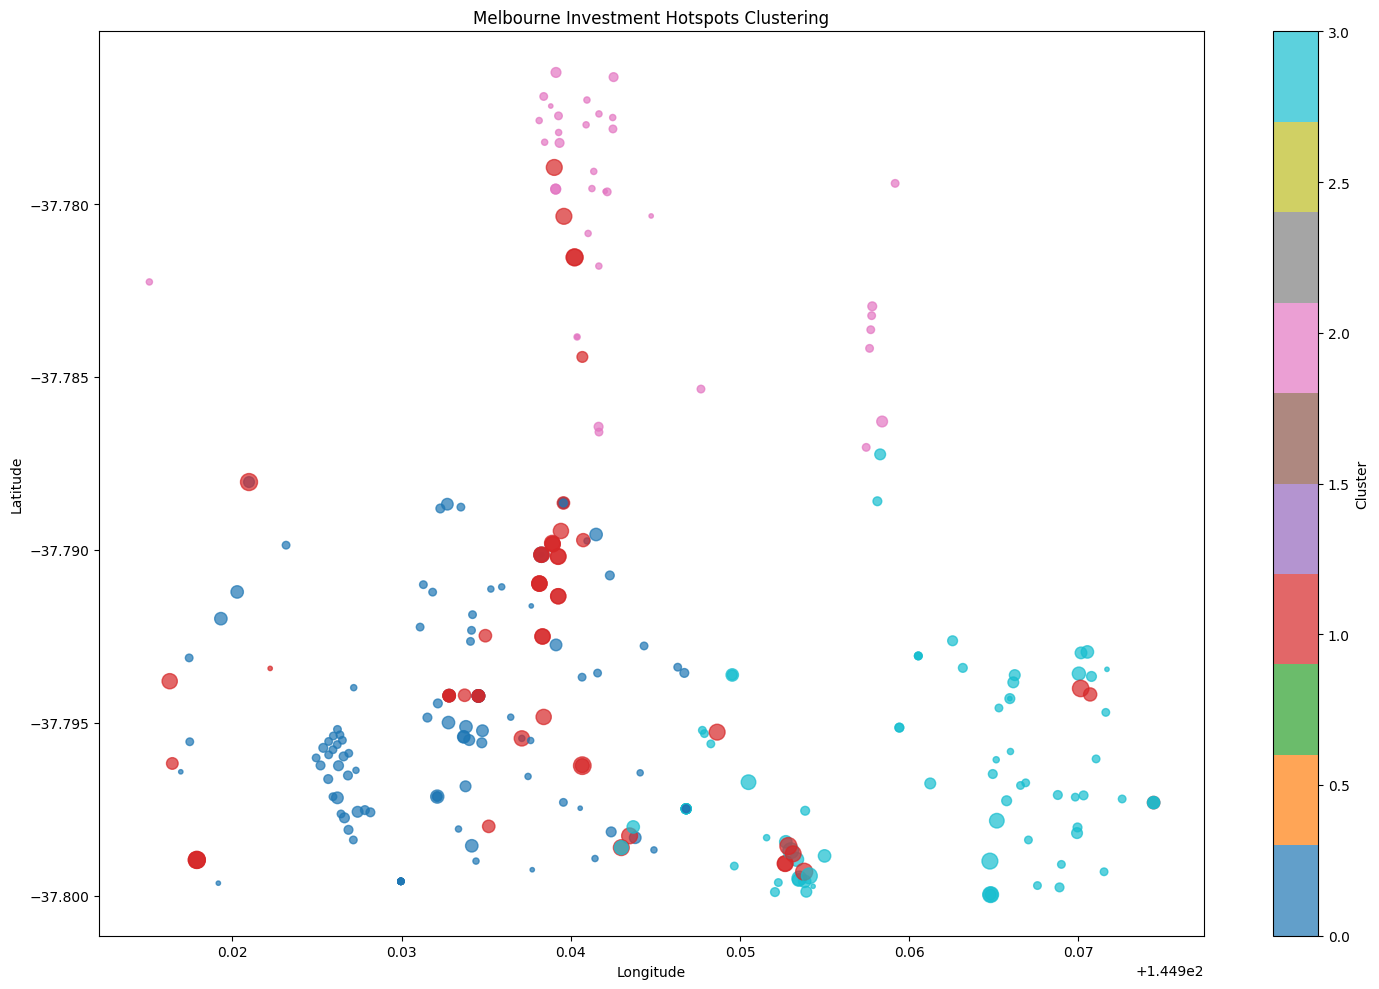

In [87]:
import numpy as np
import pandas as pd
import folium
from IPython.display import display, HTML
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

def identify_investment_hotspots(dev_df, struct_df):
    """
    Identify potential investment hotspots using clustering with Melbourne-specific locations
    
    Parameters:
    -----------
    dev_df : pandas.DataFrame
        Development activity dataframe
    struct_df : pandas.DataFrame
        Building footprints dataframe
    
    Returns:
    --------
    pandas.DataFrame
        Clustered development data with additional cluster information
    """
    # Prepare features for clustering (Melbourne-specific coordinates)
    features = ['latitude', 'longitude', 'floors_above', 'resi_dwellings']
    
    # Filter for Melbourne locations (approximate latitude and longitude bounds)
    melbourne_mask = (
        (dev_df['latitude'].between(-37.8, -37.7)) & 
        (dev_df['longitude'].between(144.9, 145.0))
    )
    cluster_data = dev_df[melbourne_mask][features].dropna()
    
    # Standardize features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(cluster_data)
    
    # Perform K-means clustering (increased to 7 for more distinct clusters)
    kmeans = KMeans(n_clusters=4, random_state=42)
    cluster_labels = kmeans.fit_predict(scaled_features)
    
    # Add cluster labels to the dataframe
    cluster_data['Cluster'] = cluster_labels
    
    # Create an interactive Folium map centered on Melbourne
    m = folium.Map(location=[-37.8136, 144.9631], zoom_start=12)
    
    # Color palette for distinct clusters
    colors = [
        'red', 'blue', 'green', 'purple', 'orange', 
        'darkred', 'lightred', 'darkblue', 'darkgreen', 
        'cadetblue', 'darkpurple', 'pink', 'lightblue', 'lightgreen'
    ]
    
    # Add markers for each cluster
    for cluster in range(4):
        cluster_subset = cluster_data[cluster_data['Cluster'] == cluster]
        
        # Calculate cluster centroid for summary
        centroid_lat = cluster_subset['latitude'].mean()
        centroid_lon = cluster_subset['longitude'].mean()
        
        # Create a marker for the cluster centroid
        folium.Marker(
            location=[centroid_lat, centroid_lon],
            popup=f"Cluster {cluster} Summary:<br>"
                  f"Total Developments: {len(cluster_subset)}<br>"
                  f"Avg Floors: {cluster_subset['floors_above'].mean():.2f}<br>"
                  f"Avg Residential Dwellings: {cluster_subset['resi_dwellings'].mean():.2f}",
            icon=folium.Icon(color=colors[cluster % len(colors)], icon='info-sign')
        ).add_to(m)
        
        # Add markers for individual developments in the cluster
        for idx, row in cluster_subset.iterrows():
            folium.CircleMarker(
                location=[row['latitude'], row['longitude']],
                radius=row['floors_above'],
                popup=f"Development Details:<br>"
                      f"Floors: {row['floors_above']}<br>"
                      f"Residential Dwellings: {row['resi_dwellings']}",
                color=colors[cluster % len(colors)],
                fill=True,
                fill_opacity=0.7
            ).add_to(m)
    
    # Display the Folium map in Jupyter Notebook
    display(HTML(m._repr_html_()))
    
    # Create an additional scatter plot for supplementary visualization
    plt.figure(figsize=(15, 10))
    scatter = plt.scatter(
        cluster_data['longitude'], 
        cluster_data['latitude'], 
        c=cluster_data['Cluster'], 
        cmap='tab10',
        s=cluster_data['floors_above']*10,
        alpha=0.7
    )
    plt.colorbar(scatter, label='Cluster')
    plt.title('Melbourne Investment Hotspots Clustering')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.tight_layout()
    plt.show()
    
    return cluster_data

# Example usage
hotspots = identify_investment_hotspots(cleaned_dev_activity_df, cleaned_building_footprints_df)

#### Overall Observations:
- The analysis reveals **four distinct clusters** of developments across Melbourne. Each cluster varies in terms of **building height**, **residential dwellings**, and overall development characteristics.

#### Cluster Analysis:

1. **Cluster 1 (High-Rise Residential/Commercial Developments):**
   - **Average Floors:** 11.22
   - **Average Residential Dwellings:** 143.84
   - **Insights:**
     - **High-rise buildings or mixed-use developments** dominate this cluster, characterized by a substantial number of residential units.
     - Likely concentrated in central Melbourne or well-connected suburban areas with high demand for both residential and commercial spaces.
     - The large residential component suggests that this cluster may include developments catering to high-density living.
  
2. **Cluster 2 (Low-Rise Residential Developments):**
   - **Average Floors:** 2.78
   - **Average Residential Dwellings:** 19.56
   - **Insights:**
     - Represents **low-rise residential developments** such as townhouses, small apartment complexes, or garden-style apartments.
     - These developments may be situated in suburban or fringe areas, where lower-density housing is in demand.
     - **Target market** may include families, first-time homebuyers, or retirees looking for quieter, less dense neighborhoods.
  
3. **Cluster 3 (Mid-Rise Residential/Mixed-Use Developments):**
   - **Average Floors:** 5.06
   - **Average Residential Dwellings:** 20.05
   - **Insights:**
     - A mix of **mid-rise residential buildings** and possibly smaller **mixed-use developments**.
     - Could be in transitional neighborhoods or near transport hubs, offering a balance between high-density and low-density living.
     - Likely designed for people looking for convenient access to both residential and commercial spaces.
  
4. **Cluster 4 (Diverse Development Types):**
   - **Average Floors:** 3.84
   - **Average Residential Dwellings:** 18.46
   - **Insights:**
     - The largest cluster with 110 developments, suggesting a **diverse range of building types**, including low-rise residential buildings, smaller commercial properties, and potentially mixed-use buildings.
     - The moderate building height and dwelling count imply that these could be **neighborhood developments** or suburban growth areas, where mixed-use zoning is prevalent.

### Potential Insights for Stakeholders:

- **Urban Planning:**
  - These clusters provide valuable insights into the **type and scale of developments** in different areas of Melbourne. Urban planners can use this information to ensure that infrastructure (e.g., roads, utilities, public transportation) is adequate for the specific needs of each development type. 
  - For example, **Cluster 1 (high-rise)** may require robust public transport links, while **Cluster 2 (low-rise)** may focus on community-oriented services such as parks and schools.

- **Development Trends:**
  - The clusters represent **different stages of urbanization**: from central, high-density developments (Cluster 1) to suburban, low-density areas (Cluster 2). The data suggests that **mid-rise and low-rise developments** are still prevalent, indicating ongoing urban growth outside the CBD.

- **Market Segmentation:**
  - Developers can tailor their projects to target specific market segments. **Cluster 1** could appeal to investors or developers targeting high-income professionals or city dwellers, while **Cluster 2** might cater to individuals or families seeking more affordable, spacious living.

This cluster analysis offers a clear picture of the different types of development in Melbourne, from high-rise buildings in the city center to low-rise, suburban developments. By further analyzing the spatial distribution and correlating these clusters with other factors, developers, urban planners, and investors can make more informed decisions about future developments and investments.

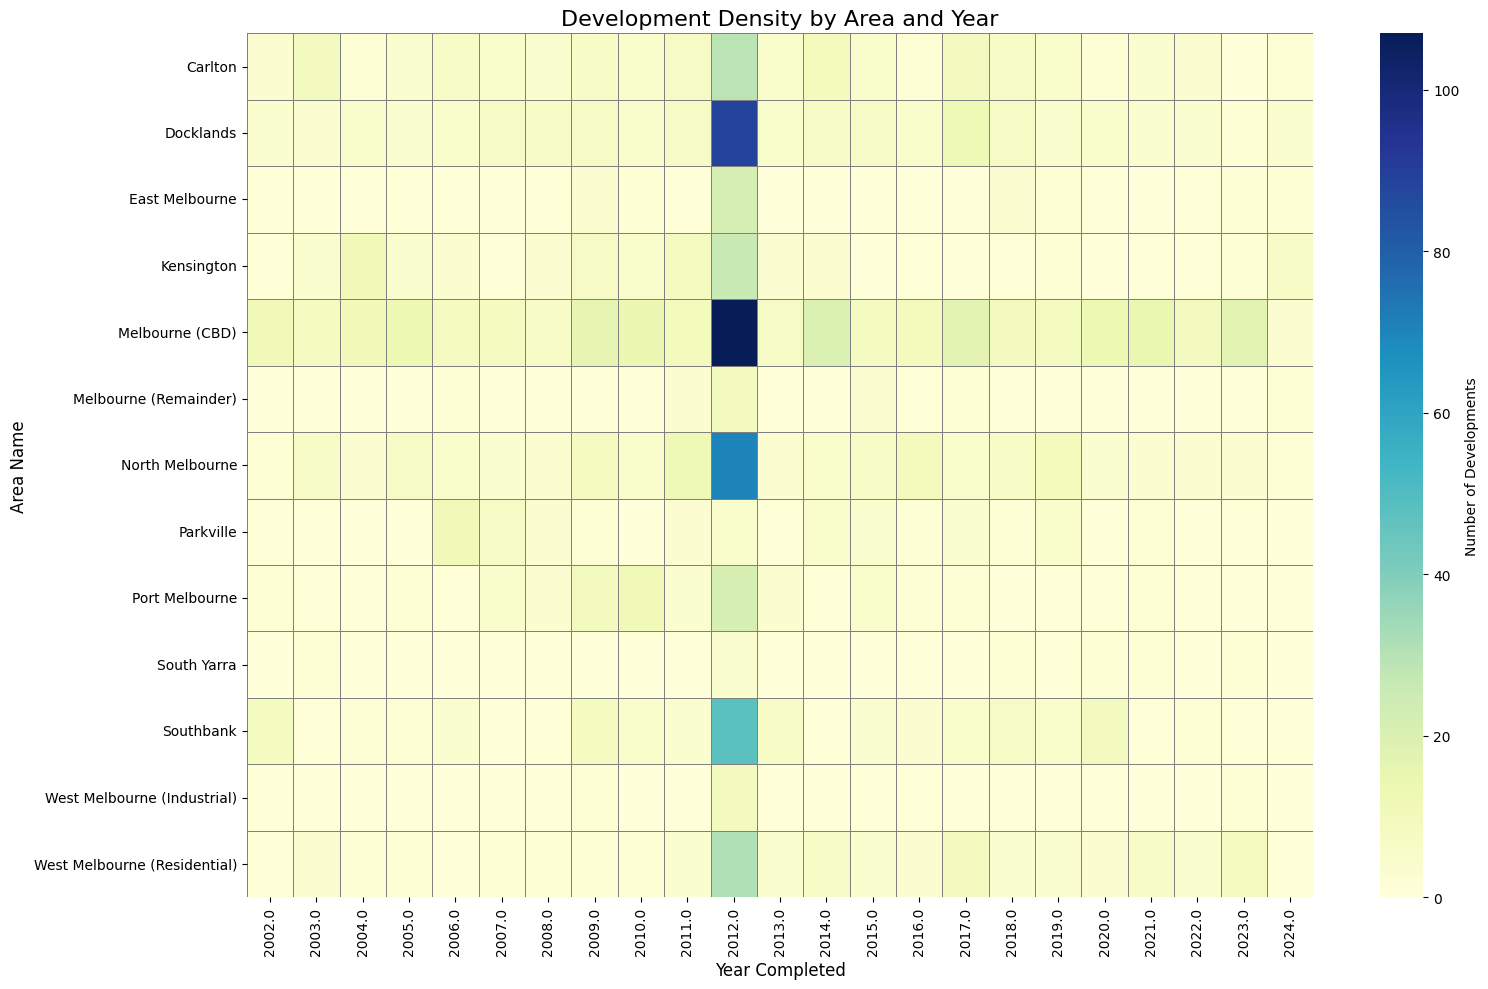

In [ ]:
def plot_heatmap_density(dev_df):
    """Generate heatmap for development density by area and year."""
    density_data = dev_df.groupby(["clue_small_area", "year_completed"]).size().unstack(fill_value=0)

    plt.figure(figsize=(16, 10))
    sns.heatmap(
        density_data,
        cmap="YlGnBu",
        linewidths=0.5,
        linecolor="gray",
        cbar_kws={"label": "Number of Developments"}
    )
    plt.title("Development Density by Area and Year", fontsize=16)
    plt.xlabel("Year Completed", fontsize=12)
    plt.ylabel("Area Name", fontsize=12)
    plt.tight_layout()
    plt.show()

def plot_stacked_area_chart(dev_df):
    """Generate stacked area chart for development composition over time."""
    yearly_composition = dev_df.groupby("year_completed").agg(
        Residential_Dwellings=("resi_dwellings", "sum"),
        Car_Spaces=("car_spaces", "sum"),
        Office_Floor_Space=("office_flr", "sum"),
        Retail_Floor_Space=("retail_flr", "sum"),
    ).reset_index()

    plt.figure(figsize=(14, 8))
    plt.stackplot(
        yearly_composition["year_completed"],
        yearly_composition["Residential_Dwellings"],
        yearly_composition["Car_Spaces"],
        yearly_composition["Office_Floor_Space"],
        yearly_composition["Retail_Floor_Space"],
        labels=[
            "Residential Dwellings",
            "Car Spaces",
            "Office Floor Space",
            "Retail Floor Space",
        ],
        colors=["#4daf4a", "#377eb8", "#e41a1c", "#ff7f00"],
        alpha=0.8,
    )
    plt.title("Development Composition Over Time", fontsize=16)
    plt.xlabel("Year Completed", fontsize=12)
    plt.ylabel("Cumulative Area / Count", fontsize=12)
    plt.legend(loc="upper left", fontsize=10)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()

# Plot heatmap and stacked area chart
plot_heatmap_density(cleaned_dev_activity_df)


#### Analysis of the "Development Density by Area and Year" Chart for Melbourne**


#### Overall Observations:

- **Density Fluctuations:** The chart shows significant variations in development density across different areas and years. These fluctuations could be influenced by factors like economic conditions, government policies, and changes in demand.


#### Insights for Real Estate Investors:

1. **Hot Spots:**
   - **Identifying growth areas:** Areas that consistently show high development density might indicate potential investment hot spots. These areas likely have strong demand for residential and commercial space, signaling opportunities for long-term growth and property value appreciation.
   - **For example:** The Docklands and Southbank areas show persistent development, making them prime targets for investors looking to capitalize on high-density urban environments.

2. **Timing:**
   - **Cyclical investments:** The chart's fluctuations can help investors time their entries and exits. By identifying areas entering a development phase, investors can get in early, potentially benefiting from future price increases as the area matures.
   - **Example:** If an area like West Melbourne is showing a rise in development density, an investor might choose to purchase property there before it peaks, selling at a later stage.

3. **Risk Assessment:**
   - **Declining areas:** A drop in development density could signal risks, such as market saturation, a shift in demand, or changes in the area's appeal. Investors should consider avoiding areas with consistent declines or analyze further why development activity has slowed down.
   - **Example:** If a region like South Melbourne shows sharp drops in new projects, investors should assess whether this is due to market saturation, zoning changes, or declining demand.


#### Insights for Urban Planners:

1. **Development Trends:**
   - **High-pressure zones:** Urban planners can use the chart to identify areas under high development pressure, where demand may outstrip existing infrastructure. These areas may require enhanced planning to avoid congestion, strain on utilities, and the need for transportation upgrades.
   - **Example:** The rise in development in West Melbourne suggests increased residential demand, requiring attention to public services and infrastructure to accommodate growth.

2. **Policy Impact:**
   - **Effectiveness of zoning and regulations:** The chart allows urban planners to assess how past policies or zoning regulations have shaped development density. For example, if certain areas show a boom in development, it may indicate successful policies that encourage growth.
   - **Example:** In the CBD, where development density remains high, planners might consider whether current policies have successfully supported growth without overwhelming the area.

3. **Sustainable Growth:**
   - **Balancing growth and infrastructure:** The chart helps planners pinpoint areas that may require future intervention to ensure sustainable growth. Over-concentrating development in one area without addressing the infrastructure gap can lead to long-term urban challenges.
   - **Example:** Areas like Southbank and Docklands, where high development density is consistent, may require additional planning to prevent overcrowding and ensure future sustainability.


#### Insights for Developers:

1. **Market Opportunities:**
   - **High demand locations:** Developers can use this chart to spot areas where development density is high, signaling strong demand for new projects. These areas are likely to offer higher returns on investment.
   - **Example:** West Melbourne, with rising development density, suggests a growing market for residential developments. Developers may focus on multifamily residential projects in this area.

2. **Risk Mitigation:**
   - **Avoid market saturation:** The chart can help developers spot areas where development density has plateaued or decreased. This might indicate oversupply or shifting market preferences.
   - **Example:** If development density in a suburban area starts to decrease, developers should assess whether it reflects changing preferences or market saturation, adjusting their plans accordingly.

3. **Project Planning:**
   - **Strategic decisions:** Understanding development trends across different years helps developers plan the scale and timing of new projects. For example, if an area shows high development in certain years, developers may choose to enter before it peaks to maximize returns.
   - **Example:** The CBD’s consistent development can indicate stability. Developers might plan commercial or mixed-use developments that cater to ongoing demand for office space or retail in this central area.


#### Specific Observations and Recommendations:

1. **Docklands and Southbank:** 
   - **Recommendation:** These areas have consistently shown high development density. Developers and investors should continue to monitor these zones for new opportunities, though caution is advised as competition may be high, and future growth could be constrained by market saturation.
   
2. **Melbourne (CBD):**
   - **Recommendation:** The CBD generally maintains steady development activity. Given its central location and proximity to amenities, it remains a stable area for both residential and commercial projects. Long-term investments here can be beneficial due to the city’s infrastructure and business demand.

3. **West Melbourne (Residential Growth):**
   - **Recommendation:** West Melbourne has seen a notable increase in development density, particularly in the residential sector. Developers should focus on residential projects here, particularly affordable housing or mid-rise developments, to cater to growing demand.

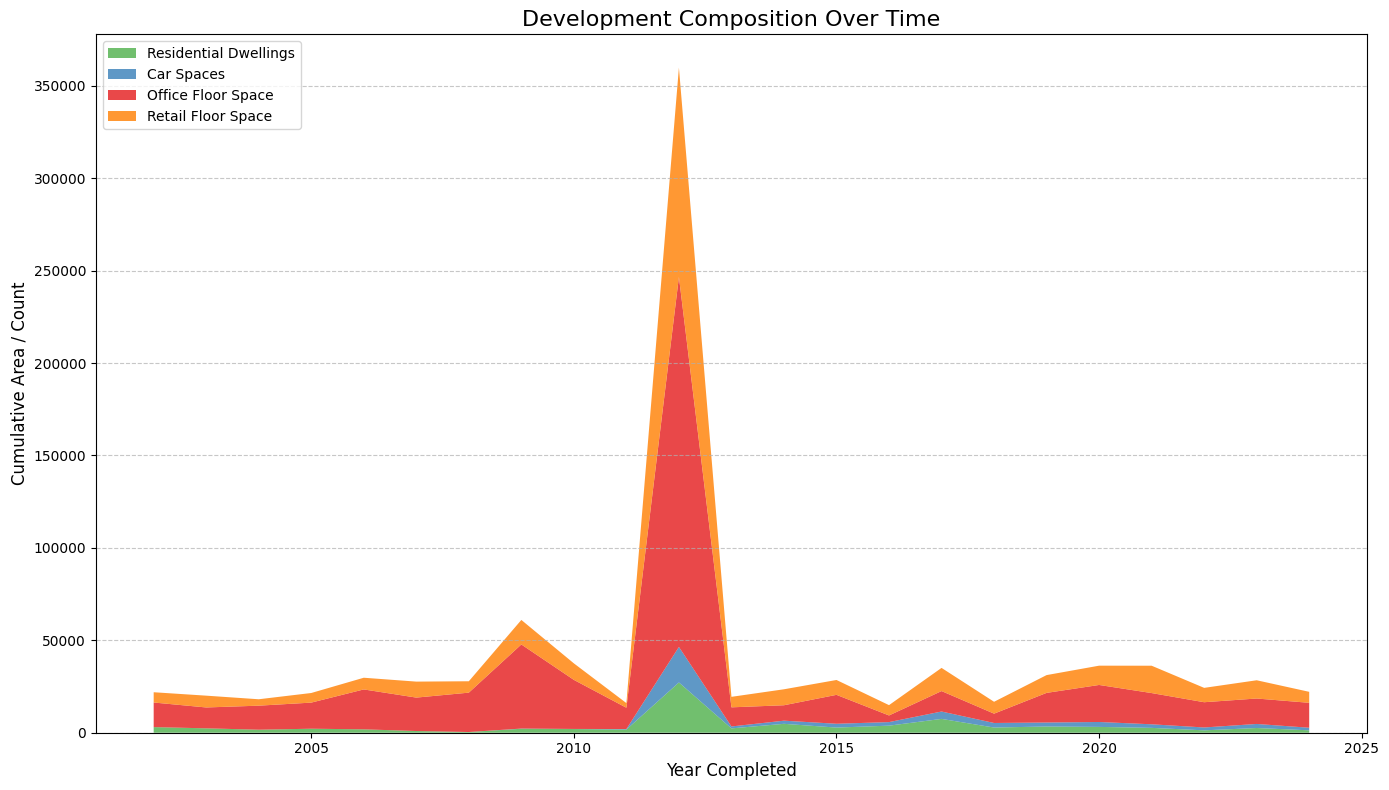

In [37]:
plot_stacked_area_chart(cleaned_dev_activity_df)

#### Analysis of "Residential Property Prices and Development Density by Area"

#### Key Observations:

- Positive Correlation: Areas with higher development density generally have higher property prices, indicating that amenities, transport, and employment hubs are key drivers of value.
- Outliers: Some areas like **Southbank** and **Docklands** show high density but lower prices, while **Toorak** and **Kew** have lower density but much higher prices. Factors like **property type** and **exclusivity** influence prices beyond just density.

#### Insights for Stakeholders:

**Real Estate Investors:**
- Growth Areas: Areas with increasing density and moderate prices offer growth opportunities.
- Stability: Low-density, high-price suburbs like **Toorak** may provide stable, long-term returns.
- Risk: High-density areas could face competition and saturation, affecting future growth.

**Urban Planners:**
- Affordable Housing: High-density areas may need affordable housing integration.
- Sustainable Growth: Promote medium-density development in well-connected locations to balance growth with livability.
- Infrastructure Needs: High-density areas require robust infrastructure investment.

**Developers:**
- Luxury Opportunities: High-density, high-price areas are ideal for luxury developments.
- Infill Projects: Lower-density, rising-price suburbs present opportunities for redevelopment.
- Positioning: In high-density areas, differentiate projects with unique amenities.

#### Key Recommendations:

- **Southbank & Docklands:** Target young professionals with smaller units; ensure adequate infrastructure.
- **Toorak & Kew:** Focus on high-end, bespoke developments, preserving heritage.
- **Middle Ring Suburbs:** Explore mixed-use developments in growing areas with moderate density.

In [31]:
# Print summary statistics
print("\nKey Market Insights:")
print("-" * 50)
print(f"Total Developments: {len(cleaned_dev_activity_df)}")
print(f"Average Building Height: {cleaned_dev_activity_df['floors_above'].mean():.1f} floors")
print(f"Total Residential Dwellings: {cleaned_dev_activity_df['resi_dwellings'].sum()}")
print(f"Total Commercial Space: {cleaned_dev_activity_df['office_flr'].sum() + cleaned_dev_activity_df['retail_flr'].sum()} sqm")


Key Market Insights:
--------------------------------------------------
Total Developments: 1438
Average Building Height: 13.8 floors
Total Residential Dwellings: 83702.75
Total Commercial Space: 829389.0 sqm


## TIME SERIES FORECASTING FOR RESIDENTIAL DWELLINGS

In [39]:
dev_activity_selected = cleaned_dev_activity_df[[
    "year_completed",
    "floors_above",
    "resi_dwellings",
    "property_id",
    "longitude",
    "latitude"
]]

building_footprints_selected = cleaned_building_footprints_df[[
    "property_id",
    "structure_max_elevation",
    "footprint_type",
    "tier",
    "roof_type"
]]

merged_data = pd.merge(dev_activity_selected, building_footprints_selected, on="property_id", how="left")


In [44]:
merged_data.isnull().sum()

year_completed               0
floors_above                 0
resi_dwellings               0
property_id                  0
longitude                    0
latitude                     0
structure_max_elevation    585
footprint_type             585
tier                       585
roof_type                  585
dtype: int64

In [45]:
merged_data.fillna({
    "structure_max_elevation": 0,
    "footprint_type": "Unknown",
    "tier": 0,
    "roof_type": "Unknown"
}, inplace=True)

In [46]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4893 entries, 0 to 4892
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   year_completed           4893 non-null   float64
 1   floors_above             4893 non-null   float64
 2   resi_dwellings           4893 non-null   float64
 3   property_id              4893 non-null   int64  
 4   longitude                4893 non-null   float64
 5   latitude                 4893 non-null   float64
 6   structure_max_elevation  4893 non-null   float64
 7   footprint_type           4893 non-null   object 
 8   tier                     4893 non-null   float64
 9   roof_type                4893 non-null   object 
dtypes: float64(7), int64(1), object(2)
memory usage: 382.4+ KB


In [47]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
merged_data["footprint_type"] = label_encoder.fit_transform(merged_data["footprint_type"])
merged_data["roof_type"] = label_encoder.fit_transform(merged_data["roof_type"])

#### Time Series Forecasting and Model Comparison

The next section of  code implements and compares three different time series forecasting models to predict the number of residential dwellings (`resi_dwellings`) based on data aggregated by `year_completed`. Here's a conceptual breakdown of each step and model:

#### Data Preparation:
- **Aggregation**: The dataset is aggregated by `year_completed` to summarize values for key features (e.g., sum of `resi_dwellings`, average of `floors_above`, `structure_max_elevation`, etc.).
- **Feature Engineering**: The features (`X`) include `year_completed`, `floors_above`, `structure_max_elevation`, `longitude`, and `latitude`, with the target (`y`) being the sum of `resi_dwellings` for each year.

#### Model Implementation:
1. **XGBoost (Extreme Gradient Boosting)**:
   - XGBoost is a powerful machine learning algorithm often used for regression tasks. It builds decision trees sequentially to reduce prediction errors.
   - The model is trained on `X_train` and `y_train`, and predictions are made for `X_test`. The Mean Squared Error (MSE) is calculated to assess the model's accuracy.

2. **ARIMA (AutoRegressive Integrated Moving Average)**:
   - ARIMA is a classical statistical model used for time series forecasting. It relies on the assumption that the future value depends linearly on its past values and errors.
   - The ARIMA model is fit to the `y_train` time series, and future values are predicted using the trained model. MSE is also calculated to assess the prediction accuracy.

3. **Prophet (by Facebook)**:
   - Prophet is a time series forecasting tool designed to handle missing data and seasonality. It is fit using a dataset containing `year_completed` (renamed to `ds`) and `resi_dwellings` (renamed to `y`).
   - The model generates predictions, and a future dataframe is created to extend the forecast. Prophet’s built-in visualization shows the trend, seasonal components, and the forecasted values.

#### Model Evaluation:
- Mean Squared Error (MSE): The performance of each model is evaluated using MSE, where lower values indicate better predictive accuracy.

#### Visualization:
- XGBoost vs Actual: A line plot comparing the actual vs. predicted values from XGBoost for `resi_dwellings`.
- ARIMA vs Actual: Similar to the XGBoost plot, showing ARIMA's predictions versus actual values.
- Prophet: Prophet’s forecast is visualized with its components, showing the model's fit and the forecasted values.

#### Why This Approach?
- Diverse Model Comparison: By using three different models, this approach leverages various strengths: XGBoost for non-linear relationships, ARIMA for capturing temporal dependencies, and Prophet for handling seasonality and missing data.
- Visualization for Insights: The plots help stakeholders visually assess model performance, which is crucial for decision-making in forecasting.


Importing plotly failed. Interactive plots will not work.
c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


XGBoost Mean Squared Error: 104682044.1051836


c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


ARIMA Mean Squared Error: 20150047.92533109


23:13:51 - cmdstanpy - INFO - Chain [1] start processing
23:13:52 - cmdstanpy - INFO - Chain [1] done processing


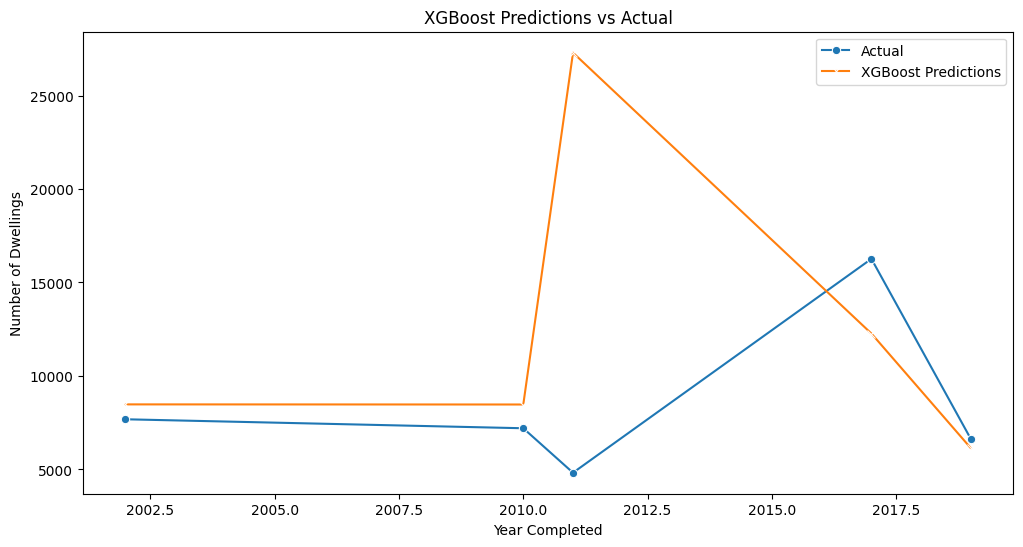

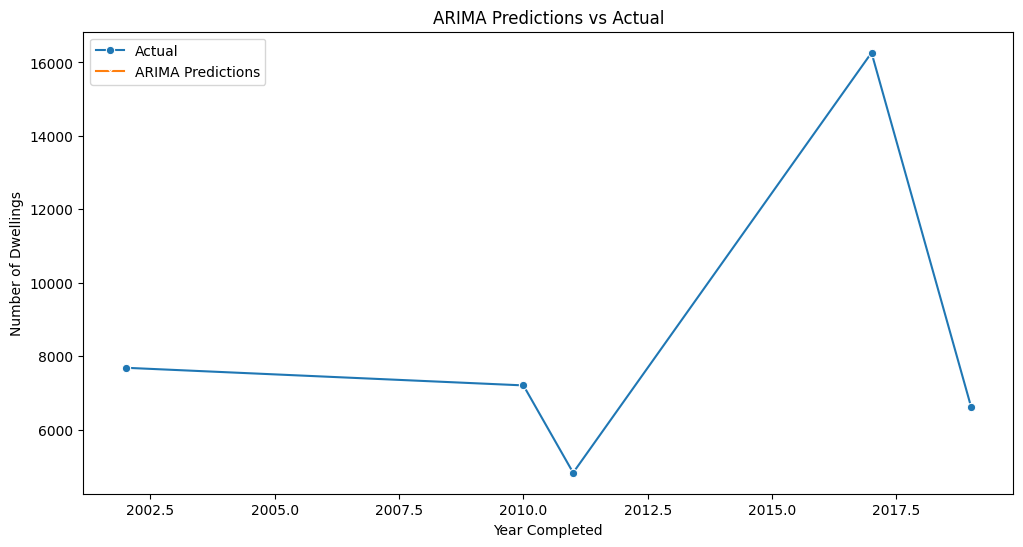

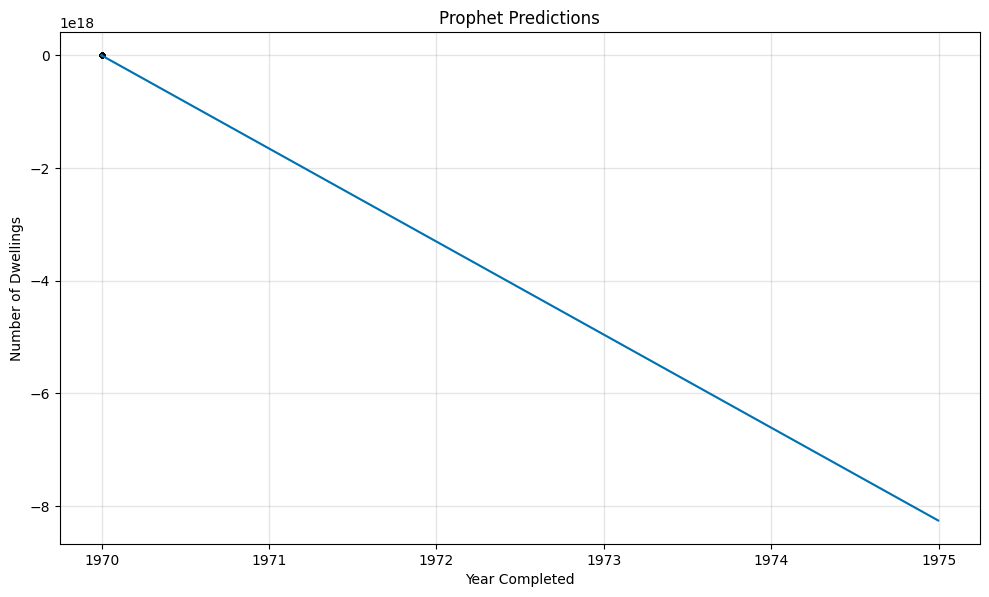

In [49]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split



# Aggregate data by year_completed
time_series_data = merged_data.groupby('year_completed').agg({
    'resi_dwellings': 'sum',
    'floors_above': 'mean',
    'structure_max_elevation': 'mean',
    'longitude': 'mean',
    'latitude': 'mean'
}).reset_index()

# Features and target
X = time_series_data[['year_completed', 'floors_above', 'structure_max_elevation', 'longitude', 'latitude']]
y = time_series_data['resi_dwellings']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ----- XGBoost Model -----
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)

# Evaluate XGBoost
xgb_mse = mean_squared_error(y_test, xgb_preds)
print(f"XGBoost Mean Squared Error: {xgb_mse}")

# ----- ARIMA Model -----
arima_model = ARIMA(y_train, order=(1, 1, 1))
arima_model_fit = arima_model.fit()
arima_preds = arima_model_fit.forecast(steps=len(y_test))

# Evaluate ARIMA
arima_mse = mean_squared_error(y_test, arima_preds)
print(f"ARIMA Mean Squared Error: {arima_mse}")

# ----- Prophet Model -----
prophet_data = time_series_data[['year_completed', 'resi_dwellings']]
prophet_data.columns = ['ds', 'y']

# Fit the model
prophet_model = Prophet()
prophet_model.fit(prophet_data)

# Make future dataframe for predictions
future = prophet_model.make_future_dataframe(periods=len(y_test), freq='Y')
prophet_preds = prophet_model.predict(future)

# ----- Visualizations -----

# XGBoost Predictions
plt.figure(figsize=(12, 6))
sns.lineplot(x=X_test['year_completed'], y=y_test, label='Actual', marker='o')
sns.lineplot(x=X_test['year_completed'], y=xgb_preds, label='XGBoost Predictions', marker='x')
plt.title('XGBoost Predictions vs Actual')
plt.xlabel('Year Completed')
plt.ylabel('Number of Dwellings')
plt.legend()
plt.show()

# ARIMA Predictions
plt.figure(figsize=(12, 6))
sns.lineplot(x=X_test['year_completed'], y=y_test, label='Actual', marker='o')
sns.lineplot(x=X_test['year_completed'], y=arima_preds, label='ARIMA Predictions', marker='x')
plt.title('ARIMA Predictions vs Actual')
plt.xlabel('Year Completed')
plt.ylabel('Number of Dwellings')
plt.legend()
plt.show()

# Prophet Predictions
prophet_model.plot(prophet_preds)
plt.title('Prophet Predictions')
plt.xlabel('Year Completed')
plt.ylabel('Number of Dwellings')
plt.show()


**Summary:**

Three models (XGBoost, ARIMA, and Prophet) were evaluated for time series forecasting of dwelling numbers. 

* **ARIMA** demonstrated the best performance with the lowest Mean Squared Error (MSE) and a reasonable visual fit to the actual data. It effectively captured underlying patterns and trends in the time series. 

* **XGBoost** exhibited a high MSE, indicating poor performance. It may not be well-suited for this type of time series data.

* **Prophet** performed poorly, generating highly inaccurate and unrealistic predictions. It was deemed unsuitable for this data.

**Recommendation:**

The **ARIMA model is recommended** as the most suitable for forecasting dwelling numbers in this scenario of forecasting residential dwellings in the city of Melbourne.
